In [1]:
!pip install aicsimageio[nd2]
!pip install nd2reader
!pip install xlsxwriter
!pip install reportlab

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Check OpenCV version
import cv2
cv2.__version__

'4.5.4'

In [3]:
from pathlib import Path
import napari
from napari.settings import get_settings
import pandas as pd
import os
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import SimpleITK as sitk
import skimage

from scipy import ndimage as ndi
from scipy.ndimage import label, zoom, binary_dilation, generate_binary_structure
from skimage.segmentation import watershed, relabel_sequential
from itertools import combinations
from vispy.color import Colormap
from matplotlib.colors import to_rgb
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from collections import defaultdict
from aicsimageio import AICSImage
from nd2reader import ND2Reader
import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn
from IPython.display import clear_output
import meshio
import statistics as st
import tetgen

from skimage import filters, morphology
from skimage.feature import peak_local_max
from skimage.morphology import ball
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
from skimage.measure import find_contours, regionprops
from skimage.draw import line as draw_line  # For line drawing

import xlsxwriter
from scipy.stats import gaussian_kde
from PIL import Image as PILImage
from reportlab.platypus import Image as RLImage
from reportlab.platypus import (
    SimpleDocTemplate, Image, Paragraph, Spacer, Table, TableStyle, PageBreak
)
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

from collections import defaultdict
from skimage.segmentation import relabel_sequential

# Enable interactive mode for napari in Jupyter
settings = get_settings()
settings.application.ipy_interactive = True

2026-02-11 10:51:43.616729: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 10:51:43.626084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 10:51:43.705011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 10:51:45.041842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Functions

In [4]:
# Image processing and utility functions

def gamma_trans(im_in, gamma):
    """Apply gamma correction to an image."""
    val_c = 255.0 / (np.max(im_in)**gamma)
    return (val_c * (im_in**gamma)).copy()

def napari_gamma(image, gamma):
    """
    Apply gamma correction in the same way as Napari.

    Parameters
    ----------
    image : numpy.ndarray
        2D or 3D image, integer or float.
        If integer, assumed to be full-range (uint8, uint16).
    gamma : float
        Same gamma exponent used in Napari.

    Returns
    -------
    corrected : numpy.ndarray
        Gamma-corrected image with the same dtype as input.
    """

    # preserve original dtype to restore at the end
    dtype = image.dtype

    # convert to float in [0,1]
    img = image.astype(np.float32)
    img /= img.max() if img.max() != 0 else 1.0

    # apply gamma
    img = img ** gamma

    # rescale back to original dtype range
    if np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
        img = np.clip(img * info.max, 0, info.max).astype(dtype)
    else:
        img = img.astype(dtype)

    return img

def contr_limit(im_in, c_min=None, c_max=None):
    """
    Stretch the contrast of the input image to the 0–255 range.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - c_min: Minimum intensity to map to 0. If None, uses im_in.min().
    - c_max: Maximum intensity to map to 255. If None, uses im_in.max().
    
    Returns:
    - Contrast-stretched image (uint8).
    """
    im_in = im_in.astype(float)
    
    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    alpha = 255.0 / (c_max - c_min)
    beta = -c_min * alpha

    im_out = alpha * im_in + beta
    #return np.clip(im_out, 0, 255).astype(np.uint8)
    return (im_out).astype(np.uint8)

def contr_stretch(im_in, c_min=None, c_max=None):
    """
    Mimic Fiji's Brightness/Contrast adjustment.
    Values below min_input become 0.
    Values above max_input become 255.
    Values in between are linearly scaled to 0–255.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - min_input: Input value to be mapped to 0.
    - max_input: Input value to be mapped to 255.
    
    Returns:
    - Adjusted image (uint8).
    """
    im_in = im_in.astype(float)

    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    # Normalize: subtract min and divide by (max - min)
    norm = (im_in - c_min) / (c_max - c_min)
    
    # Clip to [0, 1] so values outside range are fixed to 0 or 1
    norm = np.clip(norm, 0, 1)
    
    return (norm * 255).astype(np.uint8)

def napari_contrast_gamma_uint8(image, contrast_limits, gamma):
    """
    Apply Napari-style contrast limits + gamma correction,
    and return the resulting image as uint8.

    Parameters
    ----------
    image : np.ndarray
        Input image (any dtype).
    contrast_limits : tuple (clim_min, clim_max)
        Same values you see in Napari GUI.
    gamma : float
        Gamma value from Napari GUI.

    Returns
    -------
    out_uint8 : np.ndarray (uint8)
        Image transformed exactly like Napari display,
        then mapped to 0–255.
    """

    clim_min, clim_max = contrast_limits

    # Convert to float
    img = image.astype(np.float32)

    # Napari contrast normalization
    img = (img - clim_min) / (clim_max - clim_min)
    img = np.clip(img, 0.0, 1.0)

    # Napari gamma
    img = img ** gamma

    # Convert display range [0,1] → uint8 [0,255]
    out_uint8 = (img * 255).round().astype(np.uint8)

    return out_uint8

def hist_plot(im_in, stain_complete_df, thresh=0):
    """Plot histogram and CDF for each channel."""
    fig, axs = plt.subplots(1, im_in.shape[3], figsize=(15, 2))
    for c in range(im_in.shape[3]):
        hist, _ = np.histogram(im_in[:, :, :, c].flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        color = stain_complete_df.loc[stain_complete_df.index[c], 'Color']
        axs[c].plot(cdf_normalized, color='b')
        axs[c].hist(im_in[:, :, :, c].flatten(), 256, [0, 256], color=color if color != 'WHITE' else 'GRAY')
        axs[c].set_xlim([0, 256])
        axs[c].legend(('cdf', 'histogram'), loc='upper left')
        if thresh > 0:
            axs[c].plot([thresh, thresh], [0, cdf_normalized.max()], color='g')
        axs[c].set_title(stain_complete_df.index[c])
        axs[c].set_yscale('log')

def truncate_cell(val, width=15):
    """Truncate long values for display in tables."""
    val_str = str(val)
    return val_str if len(val_str) <= width else val_str[:width-3] + "..."

def merge_touching_labels(
    label_matrix,
    contact_abs_min=20,
    contact_rel_min=0.05,
    connectivity=1,
):
    """
    Merge touching labels in a 3D label matrix using union-find, but only when
    the shared boundary between two labels is large enough.

    Parameters
    ----------
    label_matrix : ndarray, int
        3D label image (0 = background).
    contact_abs_min : int
        Minimum number of boundary voxels two labels must share to be eligible
        for merging.
    contact_rel_min : float
        Minimum relative contact (shared boundary / min(volume_i, volume_j))
        to be eligible for merging.
    connectivity : {1, 2, 3}
        Neighborhood connectivity used to define touching (1=6-neighborhood,
        2≈18, 3=26-neighborhood in 3D).

    Returns
    -------
    merged : ndarray, int
        Relabeled image with selected touching labels merged.
    """
    if label_matrix.max() == 0:
        return label_matrix.copy()

    # Precompute volumes of each label
    labels, counts = np.unique(label_matrix, return_counts=True)
    volumes = dict(zip(labels.tolist(), counts.tolist()))
    volumes.pop(0, None)  # remove background

    # Connectivity: generate neighbor offsets
    offsets = []
    for dz in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dz == dy == dx == 0:
                    continue
                if connectivity == 1 and (abs(dx) + abs(dy) + abs(dz) > 1):
                    continue  # 6-neighborhood
                if connectivity == 2 and (abs(dx) + abs(dy) + abs(dz) > 2):
                    continue  # ~18-neighborhood
                offsets.append((dz, dy, dx))

    # Count how many boundary voxels two labels share
    touching_counts = defaultdict(int)

    Z, Y, X = label_matrix.shape
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                c = label_matrix[z, y, x]
                if c == 0:
                    continue
                for dz, dy, dx in offsets:
                    nz = z + dz
                    ny = y + dy
                    nx = x + dx
                    if nz < 0 or nz >= Z or ny < 0 or ny >= Y or nx < 0 or nx >= X:
                        continue
                    n = label_matrix[nz, ny, nx]
                    if n == 0 or n == c:
                        continue
                    a, b = (c, n) if c < n else (n, c)
                    touching_counts[(a, b)] += 1

    # Union-Find initialization
    all_labels = set(volumes.keys())
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    # Merge only if boundary is large enough
    for (u, v), contact in touching_counts.items():
        if u not in volumes or v not in volumes:
            continue
        vol_min = min(volumes[u], volumes[v])
        rel_contact = contact / float(vol_min)
        if contact >= contact_abs_min and rel_contact >= contact_rel_min:
            union(u, v)

    # Build label map: each label -> its root representative
    label_map = {label: find(label) for label in all_labels}

    # Apply merged labels
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root

    # Re-label to get sequential labels starting from 1
    merged, _, _ = relabel_sequential(merged)
    return merged

# def merge_touching_labels(label_matrix):
#     """Merge touching labels in a 3D label matrix using union-find."""
#     if label_matrix.max() == 0:
#         return label_matrix.copy()

#     padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
#     touching = defaultdict(set)

#     # Iterate over the inner volume (excluding padding)
#     for z in range(1, padded.shape[0] - 1):
#         for y in range(1, padded.shape[1] - 1):
#             for x in range(1, padded.shape[2] - 1):
#                 center = padded[z, y, x]
#                 if center == 0:
#                     continue
#                 neighborhood = padded[z-1:z+2, y-1:y+2, x-1:x+2].ravel()
#                 for neighbor in neighborhood:
#                     if neighbor != center and neighbor != 0:
#                         touching[center].add(neighbor)

#     # Union-Find to merge touching labels
#     all_labels = set(np.unique(label_matrix)) - {0}
#     parent = {label: label for label in all_labels}

#     def find(u):
#         while parent[u] != u:
#             parent[u] = parent[parent[u]]
#             u = parent[u]
#         return u

#     def union(u, v):
#         pu, pv = find(u), find(v)
#         if pu != pv:
#             parent[pu] = pv

#     for u, neighbors in touching.items():
#         for v in neighbors:
#             if u in parent and v in parent:
#                 union(u, v)

#     label_map = {label: find(label) for label in all_labels}

#     # Apply merged labels
#     merged = np.zeros_like(label_matrix, dtype=np.int32)
#     for label, root in label_map.items():
#         merged[label_matrix == label] = root

#     # Re-label to get sequential labels starting from 1
#     merged, _, _ = relabel_sequential(merged)
#     return merged

def remove_small_islands(binary_matrix, area_threshold):
    """Remove small connected components from a binary mask."""
    labeled_array, num_features = label(binary_matrix)
    for i in range(1, num_features + 1):
        component = (labeled_array == i)
        if component.sum() < area_threshold:
            binary_matrix[component] = 0
    return binary_matrix

def assign_labels(A, B, connectivity=1):
    """Assign labels from B to islands in A based on overlap (3D)."""
    if connectivity == 2:
        structure = np.ones((3, 3, 3))  # 26-connectivity
    else:
        structure = None  # default is 6-connectivity for 3D

    labeled_A, num_features = label(A, structure=structure)
    C = np.zeros_like(A, dtype=B.dtype)

    for i in range(1, num_features + 1):
        mask = labeled_A == i
        overlapping_labels = np.unique(B[mask & (B > 0)])
        C[mask] = overlapping_labels[0] if len(overlapping_labels) > 0 else 0

    return C

def grow_labels(label_matrix,volume_factor=5.0):
    structure = ball(volume_factor) #generate_binary_structure(3, 1)  # 6-connectivity in 3D
    output = label_matrix.copy()
    
    labels = np.unique(label_matrix)
    labels = labels[labels != 0]  # exclude background

    # Compute original volumes
    volumes = {label: np.sum(label_matrix == label) for label in labels}
    target_volumes = {label: volume_factor * vol for label, vol in volumes.items()}

    # Create masks for each label
    label_masks = {label: (label_matrix == label) for label in labels}
    grown_masks = label_masks.copy()

    # Initialize growing flags
    growing = {label: True for label in labels}

    # Start growing iterations
    while any(growing.values()):
        new_masks = {}
        occupied = np.zeros_like(label_matrix, dtype=bool)

        # Prepare current occupied space
        for label, mask in grown_masks.items():
            occupied |= mask

        for label in labels:
            if not growing[label]:
                continue
            # Grow
            dilated = binary_dilation(grown_masks[label], structure)
            # Only grow into free space
            new_mask = dilated & ~occupied
            combined = grown_masks[label] | new_mask
            if np.sum(combined) >= target_volumes[label]:
                growing[label] = False
            grown_masks[label] = combined
            new_masks[label] = combined

        # Update output matrix
        output[:] = 0
        for label, mask in grown_masks.items():
            output[mask] = label

    return output

def stardist3d_from_2d(
    img_3d,
    model_name="2D_versatile_fluo",
    nucleus_radius=5,
    voxel_size=(1.0, 0.5, 0.5),
    norm=True,
):
    """
    Apply StarDist2D slice-by-slice to a 3D stack, merge predictions,
    and split weakly connected nuclei using distance-based watershed.
    Handles anisotropic voxel spacing.

    Parameters
    ----------
    img_3d : np.ndarray
        Input 3D grayscale image, shape (Z, Y, X).
    model_name : str
        Name of pretrained StarDist2D model.
    nucleus_radius : float
        Approximate radius of nuclei in pixels (XY units).
    voxel_size : tuple(float)
        Physical voxel size as (z_spacing, y_spacing, x_spacing).
    norm : bool
        Normalize each 2D slice before prediction.

    Returns
    -------
    labels_split : np.ndarray
        3D labeled array (int32), same shape as input.
    """

    assert img_3d.ndim == 3, "Input must be 3D (Z, Y, X)"
    z_spacing, y_spacing, x_spacing = voxel_size

    print(f"Running StarDist2D on {img_3d.shape[0]} z-slices...")
    model = StarDist2D.from_pretrained(model_name)

    labels_3d = np.zeros_like(img_3d, dtype=np.int32)
    current_label = 1

    for z in range(img_3d.shape[0]):
        img = img_3d[z]
        if norm:
            img = normalize(img, 1, 99.8, axis=None)

        labels2d, _ = model.predict_instances(img)
        labels2d = np.where(labels2d > 0, labels2d + current_label, 0)
        labels_3d[z] = labels2d
        current_label = labels2d.max() + 1

    # Merge touching objects in 3D
    labels_3d = skimage.measure.label(labels_3d > 0, connectivity=1)

    # --- Anisotropic distance-based splitting ---
    print("Computing distance transform with anisotropic voxel spacing...")
    distance = ndi.distance_transform_edt(labels_3d > 0, sampling=voxel_size)

    # Estimate local maxima using nucleus_radius as search distance in XY
    footprint = np.ones(
        (
            max(1, int(z_spacing / y_spacing)),  # thin in z
            int(nucleus_radius),
            int(nucleus_radius),
        ),
        dtype=bool,
    )

    local_max = peak_local_max(
        distance,
        footprint=footprint,
        labels=labels_3d > 0,
        exclude_border=False,
    )

    # Create markers for watershed
    markers = np.zeros_like(labels_3d, dtype=int)
    for i, coord in enumerate(local_max, start=1):
        markers[tuple(coord)] = i

    # Watershed segmentation
    print("Running 3D watershed to split connected nuclei...")
    labels_split = watershed(-distance, markers, mask=labels_3d > 0)

    print(f"Done. Found {labels_split.max()} nuclei.")
    return labels_split


# def stardist3d_from_2d(model_name='2D_versatile_fluo', img_3d=None, norm=True):
#     """
#     Apply StarDist2D slice-by-slice to a 3D image stack and merge results.

#     Parameters
#     ----------
#     model_name : str
#         Name of pretrained StarDist2D model (e.g. '2D_versatile_fluo').
#     img_3d : np.ndarray
#         Input 3D image of shape (Z, Y, X).
#     norm : bool
#         Whether to normalize each slice individually.

#     Returns
#     -------
#     labels_3d : np.ndarray
#         3D labeled array of the same shape as img_3d.
#     """

#     assert img_3d.ndim == 3, "Input must be a 3D array (Z, Y, X)."

#     # Load pretrained 2D model
#     model = StarDist2D.from_pretrained(model_name)

#     labels_3d = np.zeros_like(img_3d, dtype=np.int32)
#     current_label = 1

#     for z in range(img_3d.shape[0]):
#         img = img_3d[z]

#         if norm:
#             img = normalize(img, 1.0, 99.8, axis=None)

#         # Predict 2D nuclei
#         labels2d, _ = model.predict_instances(img)

#         # Re-label so all IDs are unique across z
#         labels2d = np.where(labels2d > 0, labels2d + current_label, 0)
#         labels_3d[z] = labels2d
#         current_label = labels2d.max() + 1

#     # Optionally merge across z slices using 3D connectivity
#     labels_3d = skimage.measure.label(labels_3d > 0, connectivity=1)

#     return labels_3d

def make_anisotropic_footprint(radius_Z, radius_Y, radius_X):
    zz, yy, xx = np.ogrid[
        -radius_Z:radius_Z+1,
        -radius_Y:radius_Y+1,
        -radius_X:radius_X+1
    ]
    ellipsoid = ((zz / radius_Z)**2 + (yy / radius_Y)**2 + (xx / radius_X)**2) <= 1
    return ellipsoid

def merge_small_touching_labels(label_matrix, size_threshold, z_weight=2.0):
    """
    Merge small 3D labeled regions (< size_threshold) with touching neighbors,
    preferentially merging into the largest touching label.
    Large labels remain untouched.

    Parameters
    ----------
    label_matrix : np.ndarray (3D)
        Labeled 3D array (e.g., watershed segmentation output).
    size_threshold : int
        Maximum voxel volume for a region to be considered "small".
    z_weight : float, optional (default=2.0)
        Weight factor to penalize Z-direction adjacency.
        Use >1 for anisotropic stacks (Z spacing larger than XY).
        Example: if Z spacing = 2 µm and XY = 0.5 µm, z_weight ≈ 4.

    Returns
    -------
    merged : np.ndarray (3D)
        Relabeled 3D matrix where small touching regions are merged
        into larger neighbors, and all labels are renumbered sequentially.
    """

    if label_matrix.max() == 0:
        return label_matrix.copy()

    # --- Step 1: Compute region properties ---
    props = regionprops(label_matrix)
    sizes = {p.label: p.area for p in props}
    small_labels = {lbl for lbl, area in sizes.items() if area < size_threshold}

    # --- Step 2: Build adjacency map (touching neighbors) ---
    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    z_range = [-1, 0, 1]
    y_range = [-1, 0, 1]
    x_range = [-1, 0, 1]

    # Weighted neighborhood exploration for anisotropy
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue

                # Explore 26-neighborhood
                for dz in z_range:
                    for dy in y_range:
                        for dx in x_range:
                            if dz == dy == dx == 0:
                                continue
                            neighbor = padded[z + dz, y + dy, x + dx]
                            if neighbor == 0 or neighbor == center:
                                continue

                            # Apply anisotropic penalty: skip weak Z contacts
                            if abs(dz) == 1 and (abs(dx) + abs(dy)) == 0:
                                if np.random.random() < 1 / z_weight:
                                    touching[center].add(neighbor)
                            else:
                                touching[center].add(neighbor)

    # --- Step 3: Merge small regions with largest touching neighbor ---
    merged = label_matrix.copy()

    for lbl in sorted(small_labels):
        mask = (merged == lbl)
        if not np.any(mask):
            continue

        neighbors = touching.get(lbl, set())
        if not neighbors:
            continue

        # Choose the largest touching neighbor (prefer large ones)
        neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors if n not in small_labels}
        if len(neighbor_sizes) == 0:
            # If all neighbors are small, merge with the largest among them
            neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors}

        if len(neighbor_sizes) == 0:
            continue  # isolated small label

        target_label = max(neighbor_sizes, key=neighbor_sizes.get)
        merged[mask] = target_label

    # --- Step 4: Relabel sequentially starting from 1 ---
    merged, _, _ = relabel_sequential(merged)
    return merged

def voxel_volume(ri_x, ri_y, ri_z, zooms):
    return (ri_x * ri_y * ri_z) / np.prod(zooms)

def napari_contrast_gamma_uint8(image, contrast_limits, gamma):
    """
    Apply Napari-style contrast limits + gamma correction,
    and return the resulting image as uint8.

    Parameters
    ----------
    image : np.ndarray
        Input image (any dtype).
    contrast_limits : tuple (clim_min, clim_max)
        Same values you see in Napari GUI.
    gamma : float
        Gamma value from Napari GUI.

    Returns
    -------
    out_uint8 : np.ndarray (uint8)
        Image transformed exactly like Napari display,
        then mapped to 0–255.
    """

    clim_min, clim_max = contrast_limits

    # Convert to float
    img = image.astype(np.float32)

    # Napari contrast normalization
    img = (img - clim_min) / (clim_max - clim_min)
    img = np.clip(img, 0.0, 1.0)

    # Napari gamma
    img = img ** gamma

    # Convert display range [0,1] → uint8 [0,255]
    out_uint8 = (img * 255).round().astype(np.uint8)

    return out_uint8


def compute_nuclei_cytoplasm_stats(seg_stack, r_xyz, zooms):
    max_n = int(np.max(seg_stack['Nuclei']))
    nuc_positions = []
    nuc_sizes = []
    cyto_positions = []
    cyto_sizes = []

    for n in range(1, max_n + 1):
        zN, yN, xN = np.where(seg_stack['Nuclei'] == n)
        if xN.size == 0:
            nuc_positions.append((0.0, 0.0, 0.0))
            nuc_sizes.append(0.0)
        else:
            nuc_positions.append((np.mean(xN * r_xyz[0] / zooms[2]), np.mean(yN * r_xyz[1] / zooms[1]), np.mean(zN * r_xyz[2] / zooms[0])))
            nuc_sizes.append(xN.size * r_xyz[0] * r_xyz[1] * r_xyz[2] / np.prod(zooms))

        zC, yC, xC = np.where(seg_stack['Cytoplasm'] == n)
        if xC.size == 0:
            cyto_positions.append((0.0, 0.0, 0.0))
            cyto_sizes.append(0.0)
        else:
            cyto_positions.append((np.mean(xC * r_xyz[0] / zooms[2]), np.mean(yC * r_xyz[1] / zooms[1]), np.mean(zC * r_xyz[2] / zooms[0])))
            cyto_sizes.append(xC.size * r_xyz[0] * r_xyz[1] * r_xyz[2] / np.prod(zooms))

    return nuc_positions, nuc_sizes, cyto_positions, cyto_sizes


def compute_marker_stats_for_marker(marker_idx, seg_stack, filtered_img, r_xyz, zooms):
    """Compute marker stats per nucleus for a single marker channel.
    Returns: shared_labels (list of nucleus IDs), marker_sizes (list), avg_marker (list),
    marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker
    """
    # Identify marker names/keys used in seg_stack
    condition = stain_complete_df.index[marker_idx]
    marker_name = stain_complete_df['Marker'][marker_idx]

    # Keys in im_segmentation_stack: use condition (e.g., 'MACRO') and suffixes
    key_base = stain_df.index[marker_idx] if stain_df.index.name is not None else condition
    # In this pipeline, im_segmentation_stack stores keys as condition names (same as stain_df.index)
    seg_key = stain_df.index[marker_idx]

    # If marker images were stored as intensity*mask earlier, use those
    marker_img = seg_stack.get(seg_key, None)
    marker_img_cyto = seg_stack.get(seg_key + '_cyto', None)
    marker_img_pcm = seg_stack.get(seg_key + '_PCM', None)

    max_n = int(np.max(seg_stack['Nuclei']))

    shared_labels = []
    marker_sizes = []
    avg_marker = []
    std_marker = []
    marker_cyto_sizes = []
    avg_cyto_marker = []
    std_cyto_marker = []
    marker_pcm_sizes = []
    avg_pcm_marker = []
    std_pcm_marker = []
    #list_marker = []

    # If no marker images present, return empty lists
    if marker_img is None:
        return shared_labels, marker_sizes, avg_marker, marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker

    # For intensity lookup, pick the same channel index in filtered_img
    # Find which channel index corresponds to this condition
    ch_idx = None
    for i, idx in enumerate(stain_complete_df.index):
        if idx == condition:
            ch_idx = i
            break

    for n in range(1, max_n + 1):
        nuc_mask = (seg_stack['Nuclei'] == n)
        cyto_mask = (seg_stack['Cytoplasm'] == n)
        PCM_mask = (seg_stack['PCM'] == n)
        # Marker presence in the nucleus/cell region
        mask_marker_in_nucleus = (marker_img > 0) & ((nuc_mask+cyto_mask+PCM_mask) > 0)
        if np.any(mask_marker_in_nucleus):
            shared_labels.append(n)
            # marker_total (cytoplasm+PCM) measured on marker_img
            voxels = np.where(mask_marker_in_nucleus)
            count = voxels[0].size
            vol = count * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms)
            marker_sizes.append(vol)
            if ch_idx is not None:
                vals = filtered_img[voxels[0], voxels[1], voxels[2], ch_idx]
                avg_marker.append(float(np.mean(vals)) if vals.size>0 else 0.0)
                std_marker.append(float(np.std(vals)) if vals.size>0 else 0.0)
                # list_marker.append(vals if vals.size>0 else 0.0)
            else:
                avg_marker.append(0.0)
                std_marker.append(0.0)

            # cytoplasm-only
            if marker_img_cyto is not None:
                mask_marker_cyto = (marker_img_cyto > 0) & cyto_mask
                vox_c = np.where(mask_marker_cyto)
                count_c = vox_c[0].size
                marker_cyto_sizes.append(count_c * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
                if ch_idx is not None and count_c>0:
                    vals_c = filtered_img[vox_c[0], vox_c[1], vox_c[2], ch_idx]
                    avg_cyto_marker.append(float(np.mean(vals_c)))
                    std_cyto_marker.append(float(np.std(vals_c)))
                else:
                    avg_cyto_marker.append(0.0)
                    std_cyto_marker.append(0.0)
            else:
                marker_cyto_sizes.append(0.0)
                avg_cyto_marker.append(0.0)
                std_cyto_marker.append(0.0)

            # pcm-only
            if marker_img_pcm is not None:
                mask_marker_pcm = (marker_img_pcm > 0) & PCM_mask
                vox_p = np.where(mask_marker_pcm)
                count_p = vox_p[0].size
                marker_pcm_sizes.append(count_p * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
                if ch_idx is not None and count_p>0:
                    vals_p = filtered_img[vox_p[0], vox_p[1], vox_p[2], ch_idx]
                    avg_pcm_marker.append(float(np.mean(vals_p)))
                    std_pcm_marker.append(float(np.std(vals_p)))
                else:
                    avg_pcm_marker.append(0.0)
                    std_pcm_marker.append(0.0)
            else:
                marker_pcm_sizes.append(0.0)
                avg_pcm_marker.append(0.0)
                std_pcm_marker.append(0.0)

    return shared_labels, marker_sizes, avg_marker, std_marker, marker_cyto_sizes, avg_cyto_marker, std_cyto_marker, marker_pcm_sizes, avg_pcm_marker, std_pcm_marker

def compute_full_marker_stats_for_marker(marker_idx, seg_final, seg_stack, filtered_img, r_xyz, zooms):
    """Compute marker stats per nucleus for a single marker channel.
    Returns: shared_labels (list of nucleus IDs), marker_sizes (list), avg_marker (list),
    marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker
    """
    # Identify marker names/keys used in seg_stack
    condition = stain_complete_df.index[marker_idx]
    marker_name = stain_complete_df['Marker'][marker_idx]

    # Keys in im_segmentation_stack: use condition (e.g., 'MACRO') and suffixes
    key_base = stain_df.index[marker_idx] if stain_df.index.name is not None else condition
    # In this pipeline, im_segmentation_stack stores keys as condition names (same as stain_df.index)
    seg_key = stain_df.index[marker_idx]

    # If marker images were stored as intensity*mask earlier, use those
    marker_img = seg_final['Filtered image'][:,:,:,marker_idx]
    # marker_img_cyto = seg_stack.get(seg_key + '_cyto', None)
    # marker_img_pcm = seg_stack.get(seg_key + '_PCM', None)

    max_n = int(np.max(seg_stack['Nuclei']))

    shared_labels = []
    marker_sizes = []
    avg_marker = []
    std_marker = []
    marker_cyto_sizes = []
    avg_cyto_marker = []
    std_cyto_marker = []
    marker_pcm_sizes = []
    avg_pcm_marker = []
    std_pcm_marker = []
    #list_marker = []

    # If no marker images present, return empty lists
    if marker_img is None:
        return shared_labels, marker_sizes, avg_marker, marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker

    # For intensity lookup, pick the same channel index in filtered_img
    # Find which channel index corresponds to this condition
    ch_idx = None
    for i, idx in enumerate(stain_complete_df.index):
        if idx == condition:
            ch_idx = i
            break

    for n in range(1, max_n + 1):
        nuc_mask = (seg_stack['Nuclei'] == n)
        cyto_mask = (seg_stack['Cytoplasm'] == n)
        PCM_mask = (seg_stack['PCM'] == n)
        # Marker presence in the nucleus/cell region
        mask_marker_in_nucleus = ((nuc_mask+cyto_mask+PCM_mask) > 0) & (marker_img > 0) 
        #if np.any(mask_marker_in_nucleus):
        shared_labels.append(n)
        
        # marker_total (cytoplasm+PCM) measured on marker_img
        voxels = np.where(mask_marker_in_nucleus)
        count = voxels[0].size
        vol = count * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms)
        marker_sizes.append(vol)
        if ch_idx is not None:
            vals = filtered_img[voxels[0], voxels[1], voxels[2], ch_idx]
            avg_marker.append(float(np.mean(vals)) if vals.size>0 else 0.0)
            std_marker.append(float(np.std(vals)) if vals.size>0 else 0.0)
            # list_marker.append(vals if vals.size>0 else 0.0)
        else:
            avg_marker.append(0.0)
            std_marker.append(0.0)

        # cytoplasm-only
        #if marker_img_cyto is not None:
        mask_marker_cyto = (marker_img > 0) & cyto_mask
        vox_c = np.where(mask_marker_cyto)
        count_c = vox_c[0].size
        marker_cyto_sizes.append(count_c * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
        if ch_idx is not None and count_c>0:
            vals_c = filtered_img[vox_c[0], vox_c[1], vox_c[2], ch_idx]
            avg_cyto_marker.append(float(np.mean(vals_c)))
            std_cyto_marker.append(float(np.std(vals_c)))
        else:
            avg_cyto_marker.append(0.0)
            std_cyto_marker.append(0.0)
        # else:
        #     marker_cyto_sizes.append(0.0)
        #     avg_cyto_marker.append(0.0)
        #     std_cyto_marker.append(0.0)

        # pcm-only
        # if marker_img_pcm is not None:
        mask_marker_pcm = (marker_img > 0) & PCM_mask
        vox_p = np.where(mask_marker_pcm)
        count_p = vox_p[0].size
        marker_pcm_sizes.append(count_p * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
        if ch_idx is not None and count_p>0:
            vals_p = filtered_img[vox_p[0], vox_p[1], vox_p[2], ch_idx]
            avg_pcm_marker.append(float(np.mean(vals_p)))
            std_pcm_marker.append(float(np.std(vals_p)))
        else:
            avg_pcm_marker.append(0.0)
            std_pcm_marker.append(0.0)
        # else:
        #     marker_pcm_sizes.append(0.0)
        #     avg_pcm_marker.append(0.0)
        #     std_pcm_marker.append(0.0)

    return shared_labels, marker_sizes, avg_marker, std_marker, marker_cyto_sizes, avg_cyto_marker, std_cyto_marker, marker_pcm_sizes, avg_pcm_marker, std_pcm_marker

def save_raw_png(arr, filename, contrast_limits=None, gamma=None):
    """
    Save a 2D numpy array to PNG while optionally applying Napari-style
    contrast limits and gamma so saved images match displayed intensities.

    Parameters
    - arr: 2D array-like
    - filename: output path
    - contrast_limits: tuple (min, max) to map to [0,1] before gamma (optional)
    - gamma: gamma exponent to apply after contrast (optional)

    Backwards-compatible: if no contrast_limits provided, tries to preserve
    dtype and dynamic range as before.
    """
    arr = np.asarray(arr)

    # If user requested Napari-style mapping, use helper
    if contrast_limits is not None:
        clim = contrast_limits
        g = 1.0 if gamma is None else float(gamma)
        try:
            out = napari_contrast_gamma_uint8(arr.astype(np.float32), (float(clim[0]), float(clim[1])), g)
            img = PILImage.fromarray(out)
            img.save(filename)
            return filename
        except Exception:
            # fallback to naive save below
            pass

    # --- Fallback / legacy behavior ---
    # Already uint8/uint16 → save as-is
    if arr.dtype == np.uint8 or arr.dtype == np.uint16:
        img = PILImage.fromarray(arr)
        img.save(filename)
        return filename

    # Float data: scale by max to choose appropriate depth
    if np.issubdtype(arr.dtype, np.floating):
        maxv = float(arr.max()) if arr.size else 0.0
        if maxv == 0:
            arr8 = np.zeros_like(arr, dtype=np.uint8)
            img = PILImage.fromarray(arr8)
            img.save(filename)
            return filename

        if maxv <= 255:
            arr_scaled = (arr / maxv) * 255.0
            arr_scaled = np.clip(arr_scaled, 0, 255).astype(np.uint8)
        else:
            arr_scaled = (arr / maxv) * 65535.0
            arr_scaled = np.clip(arr_scaled, 0, 65535).astype(np.uint16)

        img = PILImage.fromarray(arr_scaled)
        img.save(filename)
        return filename

    # Integer types other than uint8/uint16
    if np.issubdtype(arr.dtype, np.integer):
        maxv = int(arr.max()) if arr.size else 0
        if maxv <= 255:
            arr8 = arr.astype(np.uint8)
            img = PILImage.fromarray(arr8)
            img.save(filename)
            return filename
        elif maxv <= 65535:
            arr16 = arr.astype(np.uint16)
            img = PILImage.fromarray(arr16)
            img.save(filename)
            return filename
        else:
            arr16 = (arr / maxv * 65535).astype(np.uint16)
            img = PILImage.fromarray(arr16)
            img.save(filename)
            return filename

    raise ValueError("Unsupported dtype for PNG saving.")

# --------------------------------------------------------------------
# Minimal ImageProcessing wrapper
# --------------------------------------------------------------------
class ImageProcessing:
    def __init__(self, filename):
        self.filename = filename
        self.img = PILImage.open(filename)

    def as_np(self):
        return np.array(self.img)


# --------------------------------------------------------------------
# Utility: save a 2D array as grayscale PNG
# --------------------------------------------------------------------
def save_single_channel_png(img2d, fname):
    """
    Save a 2D image to PNG with adaptive scaling:
    - Keeps original intensities for analysis
    - Stretch to 0–255 only for visualization
    """
    if img2d is None or img2d.size == 0:
        return None

    arr = np.array(img2d, dtype=float)

    # Adaptive visualization scaling
    vmin = np.percentile(arr, 1)
    vmax = np.percentile(arr, 99)

    if vmax <= vmin:
        vmax = vmin + 1e-6

    arr_vis = (arr - vmin) / (vmax - vmin)
    arr_vis = np.clip(arr_vis * 255, 0, 255).astype(np.uint8)

    img = PILImage.fromarray(arr_vis)
    img.save(fname)
    return fname



# --------------------------------------------------------------------
# Crop nucleus (3D-aware)
# --------------------------------------------------------------------
def crop_nucleus_with_padding(nucleus_mask, full_img_stack, pad=20):
    """
    nucleus_mask: 3D boolean array
    full_img_stack: dict {cond: 3D array}
    """
    # pick best z slice
    if nucleus_mask.ndim == 3:
        z_counts = nucleus_mask.sum(axis=(1, 2))
        best_z = int(np.argmax(z_counts))
        nuc2d = nucleus_mask[best_z]
    else:
        best_z = 0
        nuc2d = nucleus_mask

    ys, xs = np.where(nuc2d)
    if len(xs) == 0:
        return None, best_z, None, None

    # bounding box
    y_min0 = max(0, ys.min() - pad)
    y_max0 = ys.max() + pad
    x_min0 = max(0, xs.min() - pad)
    x_max0 = xs.max() + pad

    crop_dict = {}
    heights, widths = [], []

    # crop each condition
    for cond, img3D in full_img_stack.items():
        Z, H_full, W_full = img3D.shape

        y_min = y_min0
        y_max = min(y_max0, H_full)
        x_min = x_min0
        x_max = min(x_max0, W_full)

        # keep original intensities (do not normalize here)
        cropped = img3D[best_z, y_min:y_max, x_min:x_max].astype(float)

        crop_dict[cond] = cropped
        heights.append(cropped.shape[0])
        widths.append(cropped.shape[1])

    min_H = int(min(heights)) if heights else 0
    min_W = int(min(widths)) if widths else 0

    return crop_dict, best_z, (y_min0, x_min0), (min_H, min_W)

# -----------------------------------------------------------
# Get channel titles from stain_df
# -----------------------------------------------------------

def get_stain_name(stain_df, key):
    """
    Accepts:
      - stain_df as dict-like (stain_df[key])
      - OR pandas DataFrame (stain_df.loc[key, 'stain_name'])

    Returns a clean string for the title.
    """
    try:
        # Case 1: dictionary-like
        return str(stain_df[key])
    except Exception:
        try:
            # Case 2: dataframe with a column 'stain_name'
            return str(stain_df.loc[key, 'stain_name'])
        except Exception:
            # Fallback
            return key

# Build and save merged RGB with Napari contrast/gamma applied
def save_merged_figure(
    nucleus_mask, full_img_stack, condition_colors, nucleus_id,
    seg_stack,  # NEW: pass seg_stack for cyto/PCM masks
    nucleus_color='blue', cytoplasm_color='green', pcm_color='magenta',
    pad=20, out_dir="merged_png"
):
    """
    Build merged RGB: nuclei (blue) + cytoplasm (green) + PCM (magenta) + marker overlay.
    """
    os.makedirs(out_dir, exist_ok=True)

    crop_dict, best_z, (y0, x0), (min_H, min_W) = crop_nucleus_with_padding(nucleus_mask, full_img_stack, pad=pad)
    if crop_dict is None or min_H <= 0 or min_W <= 0:
        return None

    # Initialize black RGB
    merged_rgb = np.zeros((min_H, min_W, 3), dtype=float)

    structure_opacity = 0.2
    white_rgb = np.array([1.0, 1.0, 1.0])  # Pure white
    blue_rgb = np.array([0.0,0.0,1.0])
    
    # 1. Nuclei (white @ 20%)
    if nucleus_mask.ndim == 3:
        nuc2d = nucleus_mask[best_z]
    else:
        nuc2d = nucleus_mask
    nuc_crop = nuc2d[y0:y0+min_H, x0:x0+min_W].astype(float)
    merged_rgb += nuc_crop[..., None] * blue_rgb * structure_opacity
    
    # 2+3. Dashed contours around cytoplasm + PCM (white, 20% opacity)
    structure_opacity = 0.2
    white_rgb = np.array([1.0, 1.0, 1.0])
    
    # Combined cyto + PCM mask
    cyto_mask = (seg_stack.get('Cytoplasm', np.zeros_like(nucleus_mask)) == nucleus_id)
    pcm_mask = (seg_stack.get('PCM', np.zeros_like(nucleus_mask)) == nucleus_id)
    combined_mask = cyto_mask | pcm_mask  # Union of both
    
    if np.any(combined_mask):
        # Use best_z slice
        if combined_mask.ndim == 3:
            combined_2d = combined_mask[best_z]
        else:
            combined_2d = combined_mask
        
        # Crop
        combined_crop = combined_2d[y0:y0+min_H, x0:x0+min_W].astype(float)
        
        # Create dashed contour (3px thick, 50% dash:gap)
        from skimage.measure import find_contours
        contours = find_contours(combined_crop, 0.5, fully_connected='low')
        
        # Draw on temp RGB canvas
        contour_rgb = np.zeros((min_H, min_W, 3), dtype=float)
        for contour in contours:
            # Scale contour coords back to image space
            contour[:, 0] *= min_H / combined_crop.shape[0]  # y
            contour[:, 1] *= min_W / combined_crop.shape[1]  # x
            
            # Integer positions for drawing
            contour_int = contour.astype(int)
            
            # Dash pattern: every other pixel
            for i in range(0, len(contour_int), 2):  # Step 2 for dash/gap
                if i+1 < len(contour_int):
                    # Draw 2px line segments
                    rr, cc = draw_line(int(contour_int[i,0]), int(contour_int[i,1]),
                                       int(contour_int[i+1,0]), int(contour_int[i+1,1]))
                    contour_rgb[rr, cc] = white_rgb * structure_opacity
        
        merged_rgb += contour_rgb

    # 4. Marker channels (additive overlay)
    for cond, img in crop_dict.items():
        img_small = img[:min_H, :min_W].copy()
        
        # Napari contrast/gamma
        if (cond in stain_complete_df.index) and ('Cont_min' in stain_complete_df.columns):
            try:
                clim = (stain_complete_df.loc[cond, 'Cont_min'], stain_complete_df.loc[cond, 'Cont_max'])
                gamma = stain_complete_df.loc[cond, 'Gamma'] if 'Gamma' in stain_complete_df.columns else 1.0
                img_display = napari_contrast_gamma_uint8(img_small.astype(np.float32), 
                                                          (float(clim[0]), float(clim[1])), 
                                                          float(gamma))
                img_normalized = img_display.astype(float) / 255.0
            except:
                img_normalized = img_small / (img_small.max() + 1e-6)
        else:
            img_normalized = img_small / (img_small.max() + 1e-6)
        
        color = np.array(mcolors.to_rgb(condition_colors.get(cond, 'gray')))
        merged_rgb += img_normalized[..., None] * color * 0.6  # Transparent overlay

    # Clip and convert to uint8
    merged_rgb = np.clip(merged_rgb, 0, 1.0)
    merged_uint8 = (merged_rgb * 255).astype(np.uint8)

    # Save PNG filename (not array)
    fname = os.path.join(out_dir, f"n{nucleus_id}_merged.png")
    PILImage.fromarray(merged_uint8).save(fname)
    return fname  # Return filename directly

# --------------------------------------------------------------------
# Main PDF creator
# --------------------------------------------------------------------
def create_row_pdf(output_pdf="nuclei_row_pages.pdf", pad=20, thumb_size=(2.2*inch, 2.2*inch)):

    doc = SimpleDocTemplate(output_pdf, pagesize=A4)
    story = []

    nuclei = sorted(hist_data.keys())
    if not nuclei:
        raise ValueError("hist_data is empty.")

    # derive 3 marker channels
    all_conditions = sorted({cond for nd in hist_data.values() for cond in nd.keys()})
    marker_conditions = [c for c in all_conditions if c.lower() != 'nuclei']
    marker_conditions = (marker_conditions + marker_conditions)[:3]

    # color map
    condition_colors = {
        cond: (
            stain_complete_df.loc[cond, 'Color']
            if cond in stain_complete_df.index and 'Color' in stain_complete_df.columns
            else 'gray'
        )
        for cond in marker_conditions
    }
    condition_colors = {k: ('gray' if v == 'WHITE' else v) for k, v in condition_colors.items()}

    nucleus_color = (
        stain_df.loc['NUCLEI', 'Color']
        if ('NUCLEI' in stain_df.index and 'Color' in stain_df.columns)
        else 'blue'
    )

    # ---------------------------------------------------------
    # LOOP OVER NUCLEI
    # ---------------------------------------------------------
    for n in nuclei:

        # collect per-channel stack
        full_stack = {}
        for cond in marker_conditions:
            ch_inds = np.where(stain_complete_df.index == cond)[0]
            if len(ch_inds):
                full_stack[cond] = filtered_img[:, :, :, ch_inds[0]]

        nucleus_mask = (seg_stack['Nuclei'] == n)

        crop_dict_all, best_z, (y0, x0), (min_H, min_W) = \
            crop_nucleus_with_padding(nucleus_mask, full_stack, pad=pad)

        if crop_dict_all is None:
            story.append(Paragraph(f"<b>Nucleus {n}</b>: no pixels found", styles['Heading2']))
            story.append(Spacer(1, 0.3 * inch))
            continue

        # ------------------ Save channel crops ------------------
        os.makedirs("crop_png", exist_ok=True)
        ch_pngs = []

        for cond in marker_conditions:
            img = crop_dict_all.get(cond)
            arr = np.zeros((min_H, min_W)) if img is None or img.size == 0 else img[:min_H, :min_W]
            fname = f"crop_png/n{n}_{cond}.png"
            # Use stored Napari contrast limits + gamma when available so saved crops
            # keep the same displayed intensity mapping as in the viewer.
            if (cond in stain_complete_df.index) and ('Cont_min' in stain_complete_df.columns):
                try:
                    clim = (stain_complete_df.loc[cond, 'Cont_min'], stain_complete_df.loc[cond, 'Cont_max'])
                    gamma = stain_complete_df.loc[cond, 'Gamma'] if 'Gamma' in stain_complete_df.columns else 1.0
                    save_raw_png(arr, fname, contrast_limits=clim, gamma=gamma)
                except Exception:
                    save_raw_png(arr, fname)
            else:
                save_raw_png(arr, fname)
            ch_pngs.append(fname)

        # ------------------ Save merged ------------------
        merged_png = save_merged_figure(
            nucleus_mask, full_stack, condition_colors, n,
            seg_stack=seg_stack,  # NEW: pass seg_stack
            nucleus_color=nucleus_color,
            cytoplasm_color='green', pcm_color='magenta',
            pad=pad, out_dir="merged_png"
        )
        
        if merged_png is None:  # Now returns filename or None
            merged_arr = np.zeros((min_H, min_W))
            merged_png = f"merged_png/n{n}_merged_placeholder.png"
            save_raw_png(merged_arr, merged_png)
        # else:
        #     merged_arr = ImageProcessing(merged_raw).as_np()
        #     merged_arr = merged_arr[:min_H, :min_W]
        #     merged_png = f"merged_png/n{n}_merged_fixed.png"
        #     save_raw_png(merged_arr, merged_png)

        # ------------------ Density plot ------------------
        os.makedirs("density_png", exist_ok=True)
        fig, ax = plt.subplots(figsize=(4, 2.2))
        #ax.set_title(f"Nucleus {n}")
        ax.set_xlim(0, 255)
        ax.set_ylim(0, 1.05)
        ax.grid(alpha=0.2)
    
        # For each condition, plot density if data exists
        for cond in all_conditions:
            vals = np.array(hist_data.get(n, {}).get(cond, []))
            if stain_complete_df['Color'][cond] != 'WHITE':
                color = stain_complete_df['Color'][cond]  
            else:
                color = 'GRAY'
    
            if vals.size == 0:
                # no data for this nucleus & condition: skip curve plotting
                continue
    
            # try KDE, fallback if singular
            y_grid = None
            try:
                kde = gaussian_kde(vals)
                y_grid = kde(x_grid)
            except Exception:
                # fallback: create a narrow Gaussian around the mean (handles zero-variance)
                mean_val = vals.mean()
                bw = 1.0  # small bandwidth fallback
                y_grid = np.exp(-0.5 * ((x_grid - mean_val) / bw) ** 2)
            
            # normalize y to 0-1
            if y_grid.max() > 0:
                y_norm = y_grid / y_grid.max()
            else:
                y_norm = y_grid
    
            # plot density curve
            ax.plot(x_grid, y_norm, linewidth=2, color=color)
    
            # compute mean and std from raw vals
            mean_val = float(vals.mean())
            std_val = float(vals.std())
    
            # vertical mean line (same color)
            ax.axvline(mean_val, linestyle='--', linewidth=1.5, color=color)
    
            # y position for std-line: read normalized KDE at mean (interpolate)
            y_at_mean = np.interp(mean_val, x_grid, y_norm)
    
            # horizontal std line from mean-std to mean+std (clamped to axis)
            x_start = max(0.0, mean_val - std_val)
            x_end = min(255.0, mean_val + std_val)
            ax.hlines(y_at_mean, x_start, x_end, linewidth=2, color=color)

            #ax.text(x_end, y_at_mean, str(mean_val) + " SD:" + str(std_val), color = color)
    
        # Build a legend showing all conditions with their assigned color (consistent across plots)
        legend_handles = [Line2D([0], [0], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY', lw=2) for c in all_conditions]
        ax.legend(legend_handles, all_conditions, loc='upper right', framealpha=0.9)

        plt.tight_layout()
        density_png = f"density_png/n{n}_density.png"
        fig.savefig(density_png, dpi=150, bbox_inches='tight')
        plt.close(fig)

        # ------------------ PDF Table ------------------
        density_row = [Image(density_png, width=6.0 * inch, height=2.0 * inch)]

        row2 = [Image(f, width=thumb_size[0], height=thumb_size[1]) for f in ch_pngs]
        row2.append(Image(merged_png, width=thumb_size[0], height=thumb_size[1]))

        data = [
            density_row,
            row2
        ]

        table = Table(
            data,
            colWidths=[1.5 * inch] * 4,     # 4 columns
            rowHeights=[2.0 * inch, thumb_size[1]]
        )

        table.setStyle(TableStyle([
            ('SPAN', (0, 0), (3, 0)),  # density spans 4 columns
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ]))

        story.append(Paragraph(f"<b>Nucleus {n} (Z {best_z})</b>", styles['Heading2']))
        story.append(Spacer(1, 0.05 * inch))
        story.append(table)
        story.append(PageBreak())

    doc.build(story)
    print(f"PDF saved to: {output_pdf}")

def double_plateau_hist_equalization_nd(
    img: np.ndarray,
    num_plateaus: int = 2,
    plateau_factor: float = 0.5
) -> np.ndarray:
    """
    Multi-plateau histogram equalization for 8-bit images or volumes.

    Parameters
    ----------
    img : np.ndarray
        Input image/volume, uint8. Can be 2D (H,W) or 3D (Z,H,W) or 3D color (H,W,3).
        For 3D, assumes scalar intensities (one channel).
    num_plateaus : int
        Number of plateau levels (2 = double plateau).
    plateau_factor : float
        Factor (0–1+) to compute plateau(s) from average count.

    Returns
    -------
    out : np.ndarray
        Equalized image/volume with multi-plateau clipping.
    """
    if img.dtype != np.uint8:
        raise ValueError("Input must be uint8")

    # 2D grayscale
    if img.ndim == 2:
        return _mphe_channel(img, num_plateaus, plateau_factor)

    # 3D scalar volume (e.g. Z,H,W)
    if img.ndim == 3 and img.shape[-1] != 3:
        # Flatten to 1D for histogram, then map back
        flat = img.ravel()
        flat_eq = _mphe_flat(flat, num_plateaus, plateau_factor)
        return flat_eq.reshape(img.shape)

    # 3D color (H,W,3) image: apply on luminance
    if img.ndim == 3 and img.shape[-1] == 3:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        y_eq = _mphe_channel(y, num_plateaus, plateau_factor)
        ycrcb_eq = cv2.merge([y_eq, cr, cb])
        out = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
        return out

    raise ValueError("Unsupported input shape")


def _mphe_flat(
    flat: np.ndarray,
    num_plateaus: int,
    plateau_factor: float
) -> np.ndarray:
    """Multi-plateau HE on a flat uint8 array."""
    # Compute histogram
    hist = np.bincount(flat, minlength=256).astype(np.float64)
    total_pixels = flat.size

    mean_count = total_pixels / 256.0
    base_plateau = plateau_factor * mean_count

    plateau_levels = np.linspace(
        base_plateau * 0.5,
        base_plateau * (0.5 + num_plateaus),
        num_plateaus
    )

    clipped_hist = hist.copy()

    for p in plateau_levels:
        excess = np.maximum(clipped_hist - p, 0)
        clipped_hist = np.minimum(clipped_hist, p)
        redistributed = excess.sum() / 256.0
        clipped_hist += redistributed

    cdf = np.cumsum(clipped_hist)
    cdf_norm = cdf / cdf[-1]
    lut = np.floor(255 * cdf_norm).astype(np.uint8)

    return lut[flat]


def _mphe_channel(channel: np.ndarray,
                  num_plateaus: int,
                  plateau_factor: float) -> np.ndarray:
    """2D helper using the 1D flat implementation."""
    flat = channel.ravel()
    flat_eq = _mphe_flat(flat, num_plateaus, plateau_factor)
    return flat_eq.reshape(channel.shape)

In [5]:
def merge_touching_labels(label_matrix, contact_abs_min=15, contact_rel_min=0.10, 
                         size_ratio_max=3.0, connectivity=1):
    """
    Merge touching labels selectively: only fragments/splinters, 
    NOT two large nuclei with small contact.
    """
    if label_matrix.max() == 0:
        return label_matrix.copy()

    # Precompute volumes
    labels, counts = np.unique(label_matrix, return_counts=True)
    volumes = dict(zip(labels.tolist(), counts.tolist()))
    volumes.pop(0, None)

    # Neighbor offsets for connectivity
    offsets = []
    for dz in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dz == dy == dx == 0:
                    continue
                if connectivity == 1 and (abs(dx) + abs(dy) + abs(dz) > 1):
                    continue
                offsets.append((dz, dy, dx))

    # Count shared boundary voxels between label pairs
    touching_counts = defaultdict(int)
    Z, Y, X = label_matrix.shape
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                c = label_matrix[z, y, x]
                if c == 0:
                    continue
                for dz, dy, dx in offsets:
                    nz, ny, nx = z + dz, y + dy, x + dx
                    if (0 <= nz < Z and 0 <= ny < Y and 0 <= nx < X):
                        n = label_matrix[nz, ny, nx]
                        if n > 0 and n != c:
                            a, b = sorted((c, n))
                            touching_counts[(a, b)] += 1

    # Union-Find
    all_labels = set(volumes.keys())
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    # Selective merging
    for (u, v), contact in touching_counts.items():
        vol_u, vol_v = volumes[u], volumes[v]
        vol_min, vol_max = min(vol_u, vol_v), max(vol_u, vol_v)
        rel_contact = contact / float(vol_min)
        
        # Merge only if: large absolute + large relative + similar sizes
        if (contact >= contact_abs_min and 
            rel_contact >= contact_rel_min and 
            vol_max / vol_min <= size_ratio_max):
            union(u, v)

    # Remap labels
    label_map = {label: find(label) for label in all_labels}
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root
    merged, _, _ = relabel_sequential(merged)
    return merged

# REPLACED WATERSHED PIPELINE
def watershed_nuclei(im_in, c, nuclei_diameter, r_zZ, r_zY, r_zX):
    """
    Complete watershed + selective merge for nuclei.
    """
    # Distance transform (unchanged)
    distance = ndi.distance_transform_edt(im_in[:, :, :, c], 
                                        sampling=[r_zZ, r_zY, r_zX])
    
    # IMPROVED peak detection for touching nuclei
    radius_X = int((nuclei_diameter / 2.0) / r_zX)
    radius_Y = int((nuclei_diameter / 2.0) / r_zY)
    radius_Z = int((nuclei_diameter / 2.0) / r_zZ)
    
    # Smaller footprint + min_distance → splits fused blobs
    footprint_small = make_anisotropic_footprint(
        int(0.6 * radius_Z), int(0.6 * radius_Y), int(0.6 * radius_X)
    )
    min_dist_um = nuclei_diameter * 0.75  # 75% diameter minimum separation
    min_dist_vox = int(np.min([min_dist_um / r_zZ, min_dist_um / r_zY, min_dist_um / r_zX]))
    
    coords = peak_local_max(
        distance,
        footprint=footprint_small,
        min_distance=min_dist_vox,  # KEY: forces separate markers
        labels=im_in[:, :, :, c].astype(np.int32)
    )
    
    # Markers (unchanged)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    
    # Watershed (unchanged)
    im_out = markers #watershed(-distance, markers, mask=im_in[:, :, :, c])
    
    # Size estimate for your other function
    size_nuclei = np.pi * 4.0 * (np.mean([radius_X, radius_Y])**3.0) / 3.0
    
    # SELECTIVE MERGE (replaces your old merge_touching_labels)
    # im_out = merge_touching_labels(
    #     im_out,
    #     contact_abs_min=15,      # tune
    #     contact_rel_min=0.10,    # tune  
    #     size_ratio_max=3.0,      # protects large nuclei
    #     connectivity=1
    # )
    
    # Your existing cleanup (optional)
    #im_out = merge_small_touching_labels(im_out, size_nuclei, z_weight=r_zZ/r_zX)
    
    return im_out

In [6]:
import numpy as np
from scipy import ndimage as ndi

def shrink_to_markers(binary_3d, connectivity=1, max_iter=200):
    """
    For each connected component in a 3D binary image, iteratively erode it
    until it disappears. The union of the last non-empty voxels of each island
    becomes one or more marker points (one per nucleus inside that island).

    Parameters
    ----------
    binary_3d : ndarray, bool or 0/1
        3D binary image with all nuclei (possibly fused islands).
    connectivity : {1, 2, 3}
        Connectivity for connected components and erosion
        (1 ~ 6-neighborhood, 3 ~ 26-neighborhood).
    max_iter : int
        Safety cap on number of erosions.

    Returns
    -------
    marker_image : ndarray, bool
        3D binary image with True at marker voxels.
    marker_labels : ndarray, int
        3D labeled markers (each connected marker group has a unique label).
    """

    binary_3d = binary_3d.astype(bool)

    # Label initial islands
    cc_labels, n_cc = ndi.label(binary_3d, structure=ndi.generate_binary_structure(3, connectivity))

    marker_image = np.zeros_like(binary_3d, dtype=bool)

    # Process each island independently
    for cc_id in range(1, n_cc + 1):
        cc_mask = (cc_labels == cc_id)
        if not np.any(cc_mask):
            continue

        current = cc_mask.copy()
        last_non_empty = current.copy()
        iter_count = 0

        # Structuring element for erosion
        selem = ndi.generate_binary_structure(3, connectivity)

        while iter_count < max_iter:
            eroded = ndi.binary_erosion(current, structure=selem)

            if not np.any(eroded):
                # current is the last non-empty state for this island
                last_non_empty = current
                break

            # If erosion split the island into multiple components,
            # keep going; at the very end we will have multiple points.
            current = eroded
            iter_count += 1

        # Add this island's final points to the global marker map
        marker_image |= last_non_empty

    # Optional: label markers (each connected marker cluster = one nucleus)
    marker_labels, _ = ndi.label(marker_image, structure=ndi.generate_binary_structure(3, connectivity))

    return marker_image, marker_labels

In [42]:
# TEST

def shrink_to_markers(binary_3d, connectivity=1, max_iter=100,
                     min_final_size=25, max_final_cc=2,
                     merge_small_touching=True, size_ratio_thresh=0.5):
    """
    Shrink each island until stable and create markers.
    Optionally merge small touching marker-islands into larger neighbors.

    Returns
    -------
    marker_image : bool
    marker_labels : int
    """

    binary_3d = binary_3d.astype(bool)
    cc_labels, n_cc = ndi.label(
        binary_3d,
        structure=ndi.generate_binary_structure(3, connectivity)
    )
    marker_image = np.zeros_like(binary_3d, dtype=bool)
    selem = ndi.generate_binary_structure(3, connectivity)

    # --- shrink step ---
    for cc_id in range(1, n_cc + 1):
        cc_mask = (cc_labels == cc_id)
        current = cc_mask.copy()
        it = 0

        while np.sum(current) > min_final_size and it < max_iter:
            eroded = ndi.binary_erosion(current, structure=selem)

            # if erosion kills it completely, keep last state
            if not np.any(eroded):
                break

            # count components after erosion
            n_cc_eroded = ndi.label(eroded, structure=selem)[1]
            if n_cc_eroded > max_final_cc:
                break  # keep pre-split state

            current = eroded
            it += 1

        marker_image |= current

    # label marker islands
    marker_labels, n_markers = ndi.label(
        marker_image,
        structure=ndi.generate_binary_structure(3, connectivity)
    )

    if not merge_small_touching or n_markers <= 1:
        return marker_image, marker_labels

    # --- adjacency + size-based merging ---
    # compute sizes
    labels, counts = np.unique(marker_labels, return_counts=True)
    sizes = dict(zip(labels.tolist(), counts.tolist()))
    sizes.pop(0, None)  # remove background

    Z, Y, X = marker_labels.shape
    offsets = []
    for dz in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dz == dy == dx == 0:
                    continue
                # 6-neighborhood if connectivity==1, else denser
                if connectivity == 1 and (abs(dx)+abs(dy)+abs(dz) > 1):
                    continue
                offsets.append((dz, dy, dx))

    # build adjacency set
    neighbors = defaultdict(set)
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                c = marker_labels[z, y, x]
                if c == 0:
                    continue
                for dz, dy, dx in offsets:
                    nz, ny, nx = z+dz, y+dy, x+dx
                    if 0 <= nz < Z and 0 <= ny < Y and 0 <= nx < X:
                        n = marker_labels[nz, ny, nx]
                        if n > 0 and n != c:
                            neighbors[c].add(n)

    # decide reassignment: each label may be reassigned to one bigger neighbor
    new_label = {lab: lab for lab in sizes.keys()}

    for lab, neighs in neighbors.items():
        if not neighs:
            continue
        size_lab = sizes[lab]
        # find biggest neighbor
        big = max(neighs, key=lambda L: sizes.get(L, 0))
        size_big = sizes.get(big, 0)
        if size_big <= 0:
            continue
        # if lab is at least 50% smaller than the biggest neighbor, merge into it
        if size_lab <= size_ratio_thresh * size_big:
            new_label[lab] = big

    # apply reassignment
    relabeled = marker_labels.copy()
    for lab, target in new_label.items():
        if lab != target:
            relabeled[marker_labels == lab] = target

    # relabel to consecutive integers
    final_labels, _ = ndi.label(relabeled > 0,
                                structure=ndi.generate_binary_structure(3, connectivity))

    final_markers = final_labels > 0
    return final_markers, final_labels

# INPUTS

### File upload

In [8]:
# Load TIFF file and extract image data
input_file = 'EB-014_M1_ST_BX15043_20x.nd2'
big_image=True
ROI = [500, 1600, 0, 2000, 30, 80] #XYZ - put 0 to keep the original value

In [9]:
meta = AICSImage(input_file)
if big_image:
    x0, x1, y0, y1, z0, z1 = ROI
    if x1==0:
        x1 = meta.shape[0]
    if y1==0:
        y1 = meta.shape[1]
    if z1==0:
        z1 = meta.shape[2]
    # Get lazy dask array in a known order, e.g. "TCZYX"
    lazy = meta.get_image_dask_data("ZYXC")
    sub = lazy[z0:z1, y0:y1, x0:x1, :]
    # Actually load this subset into memory
    img = sub.compute()
    ROI = [0, 0, 0, 0, 0, 0]
else:
    img = meta.get_image_data("XYZ", T=0) 

print(img.shape)

(50, 2000, 1100, 4)


In [10]:
# Get physical pixel sizes
r_X = meta.physical_pixel_sizes.X #um/px
r_Y = meta.physical_pixel_sizes.Y #um/px
r_Z = meta.physical_pixel_sizes.Z #um/px
print([r_X, r_Y, r_Z])

if big_image==False:
    imdata=meta.get_image_data()
    imtype=imdata.dtype
    bdepth=imtype.itemsize*8
    print(imtype)

with ND2Reader(input_file) as nd2:
    print("Date:", nd2.metadata.get("date"))
    print("Channels:", nd2.metadata.get("channels"))

[0.332469350440108, 0.332469350440108, 0.8]
Date: 2025-12-12 17:31:38
Channels: ['647_20x', '568_20x', '488_20x', 'DAPI_20x']


### Sample

In [11]:
nuclei_diameter=10 #um
cell_diameter=30 #um

cyto_factor=3.0
PCM_factor=4.0

stain_dict = {
    'NUCLEI': ['DAPI', 'DAPI_20x', 'Blue'],
    'MACRO': ['F4_80', '488_20x', 'Green'],
    'M1': ['iNOS', '568_20x', 'Red'],
    'M2': ['CD206', '647_20x', 'White']
}

### Image

In [12]:
scale_factor=0.5
zoom_factors = [1.0, 1.0, 1.0] #XYZ
zoom_factors = [x * scale_factor for x in zoom_factors]

### Setup

In [13]:
name_setup = 'PRO_EB-014b'
use_setup = True
trig_stardist = False  # Set to True to use StarDist model
multilabel=True

## INFORMATION

In [14]:
nuclei_radius=nuclei_diameter*0.5 #um
cell_radius=cell_diameter*0.5 #um

nuclei_volume=np.ceil(4.0*((nuclei_radius)**3.0)*np.pi/3.0) #um^3
cell_volume=np.ceil(4.0*((cell_radius)**3.0)*np.pi/3.0) #um^3

x0, x1, y0, y1, z0, z1 = ROI

if x1==0:
    x1 = img.shape[0]
if y1==0:
    y1 = img.shape[1]
if z1==0:
    z1 = img.shape[2]

if big_image:
    im_original = img.astype('float32')
    im_original_ROI = im_original.copy()
else:
    im_original = meta.get_image_data("ZYXC", S=0, T=0).astype('float32')
    im_original_ROI = im_original[z0:z1,y0:y1,x0:x1,:]

im_final_stack={'Original image': im_original_ROI}

In [15]:
if big_image:
    # Ensure `Original image` has axes Z,Y,X,C and squeeze singleton time axis
    orig = im_final_stack['Original image']
    try:
        shape = orig.shape
    except Exception:
        shape = None
    print('Original image shape before fix:', shape)
    if shape is not None:
        if len(shape) == 5:
            # common order Z,Y,X,C,T -> drop T if singleton
            if shape[4] == 1:
                orig = orig[..., 0]
        if len(orig.shape) == 4:
            # ensure channels are last: if last axis looks large (likely X), detect small axis as channel
            if orig.shape[-1] > 50:
                chan_axis = next((i for i, s in enumerate(orig.shape) if s < 50), None)
                if chan_axis is not None and chan_axis != 3:
                    import numpy as np
                    orig = np.moveaxis(orig, chan_axis, -1)
    im_final_stack['Original image'] = orig
    print('Original image shape after fix:', getattr(orig, 'shape', None))

Original image shape before fix: (50, 2000, 1100, 4)
Original image shape after fix: (50, 2000, 1100, 4)


### Information about the staining

In [16]:
# Define staining dictionary and create DataFrame
stain_dict = {k.upper(): [item.upper() if isinstance(item, str) else item for item in v] for k, v in stain_dict.items()}
stain_df = pd.DataFrame.from_dict(stain_dict, orient='index', columns=['Marker', 'Laser', 'Color'])
laser_order=nd2.metadata.get("channels")

# Map fluorophore to its order index
order_map = {name.strip().upper(): i for i, name in enumerate(laser_order)}
stain_df['order'] = stain_df['Laser'].map(order_map)

# Sort by that and drop helper column
stain_df = stain_df.sort_values('order').drop(columns='order')

stain_df.index.name = 'Condition'

if 'NUCLEI' not in stain_df.index:
    print('No nuclei condition!')

In [17]:
# Visualize each channel using napari
im_in=im_final_stack['Original image'].copy()

viewer_0 = napari.Viewer()
for c, c_name in enumerate(stain_df['Marker']):
    #im_in = meta.get_image_data("ZYX", C=c, S=0, T=0).astype('float32')
    im_channel = im_in[:,:,:,c]

    # Stretch to [0, 255]
    im_8b = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
    
    viewer_0.add_image(im_8b, name=f"{stain_df.index[c]} ({c_name})", 
                        colormap=stain_df['Color'][c], blending='additive', scale=[r_Z,r_Y,r_X])

    viewer_0.scale_bar.visible = True
    viewer_0.scale_bar.unit = 'um'

### Acquisition processing setup

In [18]:
# Setup for acquisition and contrast/gamma settings
im_in=im_final_stack['Original image'].copy()

stain_df = stain_df.reset_index(drop=False)
stain_initial_df = stain_df.copy()
stain_initial_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
stain_initial_df[['Cont_min', 'Cont_max', 'Gamma']] = [0, 255, 1]
stain_complete_df=stain_initial_df.copy()

setup_path = f"{name_setup}_setup.csv"
if use_setup and os.path.exists(setup_path):
    stain_setup_df = pd.read_csv(setup_path)
    stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
    for idx in stain_complete_df.index:
        if idx in stain_setup_df.index:
            stain_complete_df.loc[idx] = stain_setup_df.loc[idx]
            stain_complete_df['Color'] = stain_initial_df['Color']
        else:
            use_setup = False

if not use_setup or not os.path.exists(setup_path):
    stain_complete_df=stain_initial_df.copy()
    settings.application.ipy_interactive = False
    viewer_1 = napari.Viewer()
    for c, idx in enumerate(stain_complete_df.index):
        im_channel = im_in[:,:,:,c]
        im_channel = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
        viewer_1.add_image(im_channel, name=f"{idx[0]} ({idx[1]})", colormap=stain_initial_df.loc[idx]['Color'], blending='additive')
    napari.run()
    image_layers = [layer for layer in viewer_1.layers if isinstance(layer, napari.layers.Image)]
    contrast_limits = {layer.name: layer.contrast_limits for layer in image_layers}
    gamma_val = {layer.name: layer.gamma for layer in image_layers}
    stain_complete_df.sort_index(inplace=True)
    for c, idx in enumerate(stain_complete_df.index):
        name = f"{idx[0]} ({idx[1]})"
        stain_complete_df.loc[idx, 'Cont_min'] = int(contrast_limits[name][0])
        stain_complete_df.loc[idx, 'Cont_max'] = int(contrast_limits[name][1])
        stain_complete_df.loc[idx, 'Gamma'] = gamma_val[name]
    if os.path.exists(setup_path):
        stain_setup_df = pd.read_csv(setup_path)
        stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
        for idx in stain_complete_df.index:
            stain_setup_df.loc[idx] = stain_complete_df.loc[idx]
    else:
        stain_setup_df = stain_complete_df.copy()
    stain_csv_setup_df = stain_setup_df.reset_index().sort_values(by='Condition')
    stain_csv_setup_df = stain_csv_setup_df[['Condition', 'Marker', 'Laser', 'Cont_min', 'Cont_max', 'Gamma']]
    stain_csv_setup_df.to_csv(setup_path, index=False)

stain_df = stain_df.set_index('Condition')
stain_complete_df = stain_complete_df.reset_index().set_index('Condition')
stain_complete_df = stain_complete_df.loc[stain_df.index]
stain_complete_df = stain_complete_df[['Marker', 'Laser', 'Color', 'Cont_min', 'Cont_max', 'Gamma']]
original_stain_complete_df=stain_complete_df.copy()

In [19]:
# Display stain settings DataFrame
stain_complete_df

,Marker,Laser,Color,Cont_min,Cont_max,Gamma
Condition,,,,,,
M2,CD206,647_20X,WHITE,22,207,1
M1,INOS,568_20X,RED,27,198,1
MACRO,F4_80,488_20X,GREEN,33,140,1
NUCLEI,DAPI,DAPI_20X,BLUE,90,141,1


## IMAGE PROCESSING

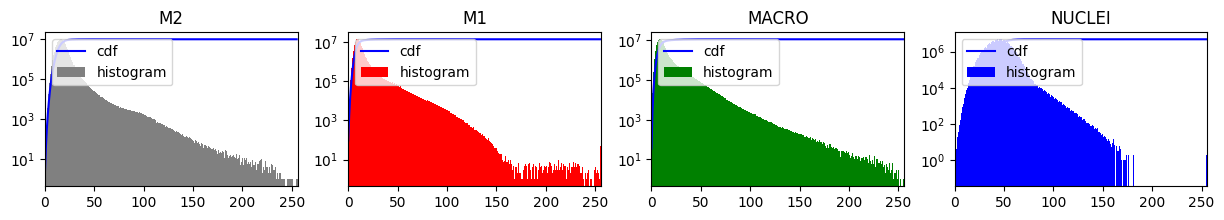

In [20]:
# Load and normalize image data for all channels
im_in=im_final_stack['Original image'].copy()
im_out=im_in.copy()
for c in range(im_in.shape[3]):
    im_ori = im_in[:, :, :, c].copy()
    im_out[:, :, :, c] = ((im_ori - im_ori.min()) / (im_ori.max() - im_ori.min()) * 255).clip(0, 255).astype('uint8')

im_final_stack['Normalized image']=im_out.copy()

# Plot histogram for each channel
hist_plot(im_final_stack['Normalized image'], stain_complete_df)

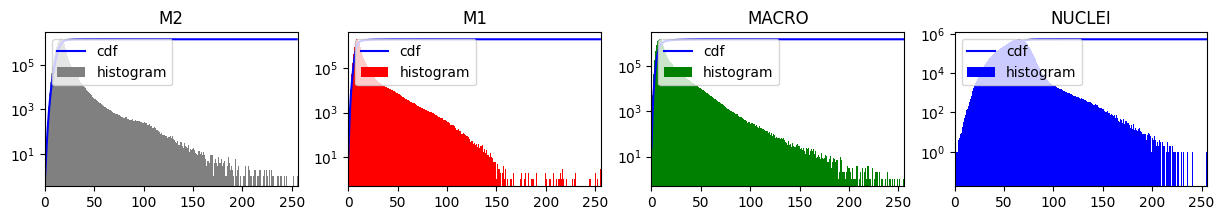

In [21]:
# Adapt resolution to isotropic
im_in=im_final_stack['Normalized image'].copy()

im_out = np.zeros((round(np.shape(im_in)[0] * (zoom_factors[0])),round(np.shape(im_in)[1] * (zoom_factors[1])),round(np.shape(im_in)[2] * (zoom_factors[2])),np.shape(im_in)[3]))

# Compute zoom factors to get isotropic spacing (same as Y and X)
r_zX = meta.physical_pixel_sizes.X/zoom_factors[0]
r_zY = meta.physical_pixel_sizes.Y/zoom_factors[1]
r_zZ = meta.physical_pixel_sizes.Z/zoom_factors[2]

# Resample image to isotropic spacing
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = zoom(im_in[:, :, :, c], zoom=zoom_factors, order=1)
    im_out[:, :, :, c] = im_out[:, :, :, c] - np.min(im_out[:, :, :, c])

    im_out[:, :, :, c] = ((im_out[:, :, :, c] - im_out[:, :, :, c].min()) / (im_out[:, :, :, c].max() - im_out[:, :, :, c].min()) * 255).clip(0, 255).astype('uint8')

im_final_stack['Zoomed image']=im_out.copy()
hist_plot(im_final_stack['Zoomed image'], stain_complete_df)

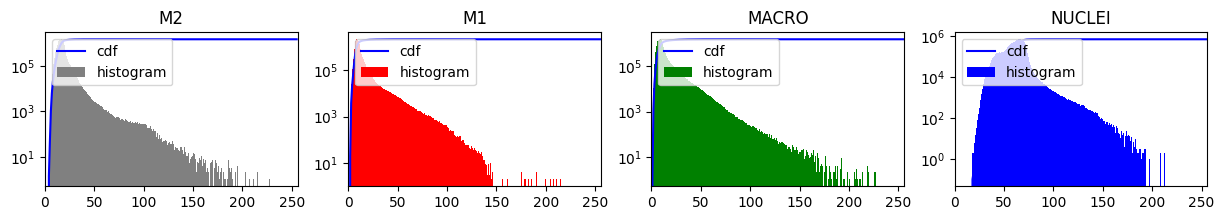

In [22]:
# Noise removal using median filter
im_in = im_final_stack['Zoomed image'].copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.median(im_in[:, :, :, c])
im_final_stack['Denoised image'] = im_out.copy()
hist_plot(im_final_stack['Denoised image'], stain_complete_df)

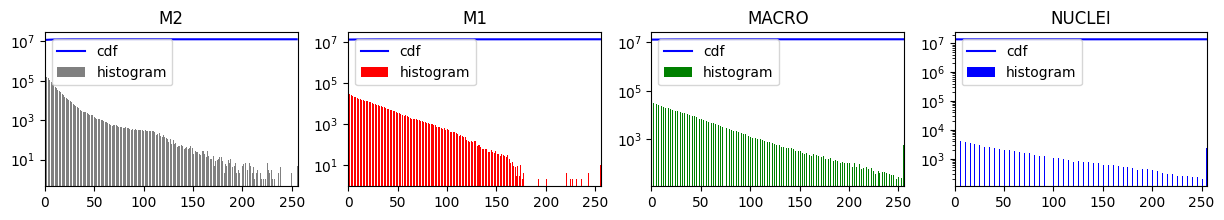

In [23]:
# Contrast and gamma adjustment for each channel
im_in = im_final_stack['Denoised image'].copy()
for c in range(im_in.shape[3]):
    idx = stain_complete_df.index[c]
    im_out[:, :, :, c] = napari_contrast_gamma_uint8(im_in[:, :, :, c], (stain_complete_df.loc[idx, 'Cont_min'], stain_complete_df.loc[idx, 'Cont_max']), stain_complete_df.loc[idx, 'Gamma'])
    
im_final_stack['Adjusted image'] = im_out.copy()
hist_plot(im_final_stack['Adjusted image'], stain_complete_df)

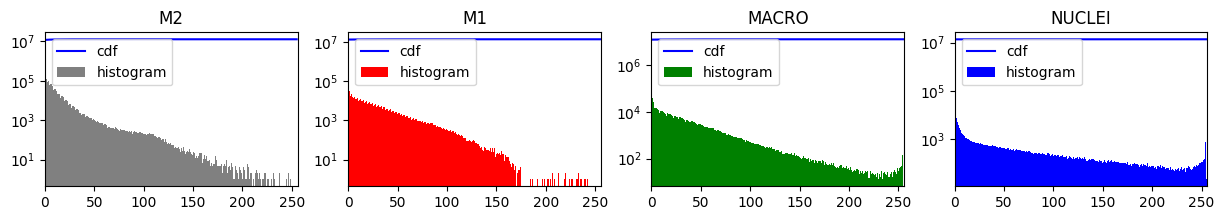

In [24]:
# Gaussian filter for smoothing
im_in = im_final_stack['Adjusted image'].copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.gaussian(im_in[:, :, :, c], 0.5, preserve_range=True)

im_final_stack['Filtered image'] = im_out.astype('uint8')
hist_plot(im_final_stack['Filtered image'], stain_complete_df)

In [25]:
# Export histograms
output_path=Path(input_file).stem + '_histograms.xlsx'
im_in = im_final_stack['Adjusted image'].copy()

with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    for c in range(im_in.shape[3]):
        # Example input: 3D array (e.g. image stack)
        im3d = im_in[:, :, :, c].copy()

        # Compute histogram
        values, counts = np.unique(im3d.astype('int'), return_counts=True)
        hist = np.zeros(256, dtype=int)
        hist[values] = counts

        # Calculate totals, percentages, and cumulative values
        total = hist.sum()
        percentage = (hist / total) * 100
        cumulative = np.cumsum(hist)
        cumulative_percentage = np.cumsum(percentage)

        # Build DataFrame
        df = pd.DataFrame({
            "Pixel_Value": np.arange(256),
            "Count": hist,
            "Percentage": percentage,
            "Cumulative_Count": cumulative,
            "Cumulative_Percentage": cumulative_percentage
        })

        idx = stain_complete_df.index[c]
        marker = stain_complete_df.loc[idx, 'Marker']

        # Write each to a different sheet
        df.to_excel(writer, sheet_name=marker, index=False)
    
print(f"Saved to: {output_path}")

Saved to: EB-014_M1_ST_BX15043_20x_histograms.xlsx


In [26]:
# # Thresholding using Otsu, Sauvola, statistical background, gain filtering
# im_in = im_final_stack["Filtered image"].copy()
# im_out = im_in.copy()

# for c in range(im_in.shape[3]):
#     img = sitk.GetImageFromArray(im_in[:, :, :, c])

#     # Stretch for Otsu
#     rescaler = sitk.RescaleIntensityImageFilter()
#     rescaler.SetOutputMinimum(0)
#     rescaler.SetOutputMaximum(255)
#     stretched = rescaler.Execute(img)

#     # Otsu thresholds
#     th_filter = sitk.OtsuThresholdImageFilter()
#     _ = th_filter.Execute(stretched)
#     otsu_value = th_filter.GetThreshold()

#     _ = th_filter.Execute(img)
#     otsu_value2 = th_filter.GetThreshold()

#     # Sizes
#     nuclei_size = int(nuclei_diameter * scale_factor / (np.mean([r_X, r_Y])))
#     cell_size = int(cell_diameter * scale_factor / (np.mean([r_X, r_Y])))

#     if stain_complete_df.index[c] == "NUCLEI":
#         window_size = 2 * nuclei_size + 1
#     else:
#         window_size = 2 * cell_size + 1

#     # Convert to array
#     arr = sitk.GetArrayFromImage(img).astype(np.float32)

#     # Sauvola threshold map
#     sauvola_value = threshold_sauvola(arr, window_size=int(window_size))

#     # Statistical background threshold
#     hist, bins = np.histogram(arr, bins=256, range=(0, arr.max()))
#     mode_bin = bins[np.argmax(hist)]

#     bg_mask = (arr >= mode_bin - 5) & (arr <= mode_bin + 5)
#     bg_vals = arr[bg_mask]
#     if bg_vals.size < window_size:
#         bg_vals = arr

#     bg_mean = bg_vals.mean()
#     bg_std = bg_vals.std() + 1e-6
#     z = 3.0
#     statistical_thr = bg_mean + z * bg_std

#     print(bg_mean)

#     # Final combined threshold map
#     final_thr = (
#         0.75 * sauvola_value +
#         0.15 * statistical_thr +
#         0.10 * otsu_value2
#     )

#     # Extra improvement: intensity gain check
#     # Only keep pixels that rise at least X times above background mean
#     gain = arr / (bg_mean + 1e-6)
#     mask_gain = gain > 10.0    # adjust if needed

#     # Apply threshold
#     arrayseg = (arr > final_thr) & mask_gain

#     # Remove small islands
#     min_size = np.ceil(0.8 * np.pi * ((nuclei_size / 2) ** 2))
#     im_out[:, :, :, c] = remove_small_islands(arrayseg, min_size)

# im_final_stack["Threshold image"] = im_out.copy()

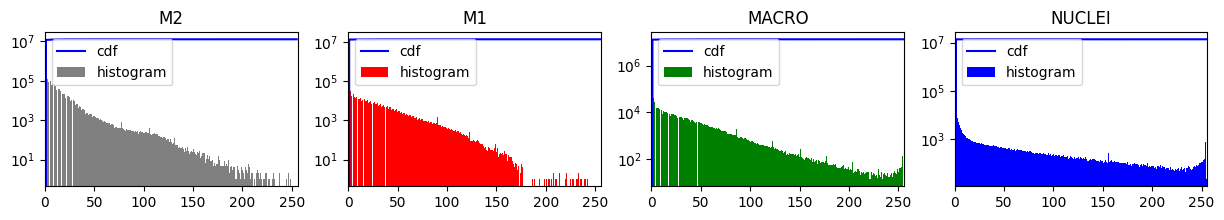

In [27]:
# Histogram equalization, supporting thresholding
im_in = im_final_stack['Filtered image'].copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = double_plateau_hist_equalization_nd(im_in[:, :, :, c].astype('uint8'), num_plateaus=2, plateau_factor=0.7)

im_final_stack['Equalized image'] = im_out.copy()
hist_plot(im_final_stack['Equalized image'], stain_complete_df)

In [28]:
# Thresholding using Otsu, Sauvola, statistical background, gain filtering
im_in = im_final_stack["Equalized image"].copy()
im_out = im_in.copy()

# Sizes
nuclei_size = int(nuclei_diameter / (np.mean([r_zX, r_zY])))
cell_size = int(cell_diameter / (np.mean([r_zX, r_zY])))

for c in range(im_in.shape[3]):
    img = sitk.GetImageFromArray(im_in[:, :, :, c])

    # Stretch for Otsu
    rescaler = sitk.RescaleIntensityImageFilter()
    rescaler.SetOutputMinimum(0)
    rescaler.SetOutputMaximum(255)
    stretched = rescaler.Execute(img)


    # Otsu thresholds
    th_filter = sitk.OtsuThresholdImageFilter()
    _ = th_filter.Execute(stretched)
    otsu_value = th_filter.GetThreshold()

    _ = th_filter.Execute(img)
    otsu_value2 = th_filter.GetThreshold()

    if stain_complete_df.index[c] == "NUCLEI":
        window_size = 1 * nuclei_size #+ 1
    else:
        window_size = 4 * cell_size + 1

    # Convert to array
    arr = sitk.GetArrayFromImage(img).astype(np.float32)

    # Sauvola threshold map
    sauvola_value = threshold_sauvola(arr, window_size=int(window_size))

    # -------- GLOBAL statistical background, excluding zeros --------
    non_zero = arr[arr > 0]

    if non_zero.size > 0:
        hist, bins = np.histogram(non_zero, bins=256, range=(0, non_zero.max()))
        mode_bin = bins[np.argmax(hist)]

        bg_mask = (arr >= mode_bin - 5) & (arr <= mode_bin + 5) & (arr > 0)
        bg_vals = arr[bg_mask]

        if bg_vals.size < 50:
            p10 = np.percentile(non_zero, 10)
            bg_vals = non_zero[non_zero <= p10]
    else:
        bg_vals = arr

    bg_mean = bg_vals.mean()
    bg_std = bg_vals.std() + 1e-6

    bg_mean_z = arr.mean()
    bg_std_z = arr.std() + 1e-6
    z = 3.0
    statistical_thr = bg_mean_z + z * bg_std_z

    # ---------------------------------------------------------------

    # 1) Soften Sauvola if it is too aggressive for large/bright cells
    # Clip Sauvola so it cannot exceed a few std above the global (zero‑including) mean
    max_sauvola = bg_mean_z + 2.0 * bg_std_z
    sauvola_clipped = np.minimum(sauvola_value, max_sauvola)

    # Final combined threshold map (slightly less Sauvola weight)
    final_thr = (
        0.60 * sauvola_clipped +
        0.25 * statistical_thr +
        0.15 * otsu_value2
    )

    # Extra improvement: intensity gain check (global, using non-zero-based bg_mean)
    gain = arr / (bg_mean + 1e-6)
    mask_gain = gain > 6.0    # tune 2–5 depending on SNR

    # 2) Rescue pixels: strong gain but slightly under final_thr
    primary = (arr > final_thr) & mask_gain
    rescue = (gain > 9.0) & (arr > statistical_thr)   # gain threshold > primary, to keep it conservative

    arrayseg = primary | rescue

    if stain_complete_df.index[c] != 'NUCLEI':
        min_size = np.ceil(0.8 * np.pi * ((nuclei_size / 2) ** 2))
    else:
        min_size= np.ceil(0.4 * np.pi * ((nuclei_size / 2) ** 2))

    # Remove small islands
    
    im_out[:, :, :, c] = remove_small_islands(arrayseg, min_size)

im_final_stack["Threshold image"] = im_out.copy()

In [43]:
# Segmentation of nuclei using watershed or StarDist
trig_stardist=False
if 'NUCLEI' in stain_df.index:
    im_in=im_final_stack['Threshold image'].copy()
    
    for c in range(im_in.shape[3]):
        if stain_complete_df.index[c] == 'NUCLEI':
            if trig_stardist:
                im_in=im_final_stack['Equalized image'].copy()
                transl=stardist3d_from_2d(img_3d=im_in[:,:,:,c],nucleus_radius=nuclei_diameter/2.0,voxel_size=(r_zZ, r_zY, r_zX))
                im_mask = transl>0
                im_mask = morphology.binary_erosion(im_mask, footprint=np.ones((2, 2, 2))).astype(im_mask.dtype)
                im_out,num = label((transl * im_mask)>0)
            else:
                # distance = ndi.distance_transform_edt(im_in[:, :, :, c],sampling=[r_zZ,r_zY,r_zX])
                # radius_X = int((nuclei_diameter / 2.0) / r_zX)
                # radius_Y = int((nuclei_diameter / 2.0) / r_zY)
                # radius_Z = int((nuclei_diameter / 2.0) / r_zZ)
                # coords = peak_local_max(distance, footprint=make_anisotropic_footprint(radius_Z, radius_Y, radius_X), labels=im_in[:, :, :, c].astype(np.int32))
                # mask = np.zeros(distance.shape, dtype=bool)
                # mask[tuple(coords.T)] = True
                # markers, _ = ndi.label(mask)
                # im_out = watershed(-distance, markers, mask=im_in[:, :, :, c])
                # #im_out = watershed_nuclei(im_in, c, nuclei_diameter, r_zZ, r_zY, r_zX)
                # #im_out = merge_touching_labels(im_out)
                # size_nuclei=np.pi*4.0*(np.mean([radius_X,radius_Y])**3.0)/3.0
                # #print(size_nuclei)
                # #im_out=merge_small_touching_labels(im_out,size_nuclei,z_weight=r_zZ/r_zX)
                # im_out = merge_touching_labels(
                #     im_out,
                #     contact_abs_min=10,      # tune for your voxel size
                #     contact_rel_min=0.25,    # tune for your nuclei size
                #     connectivity=3           # or 2/3 if you want more permissive touching
                # )
                binary_mask = im_in[:, :, :, c].copy()
                _, true_markers = shrink_to_markers(binary_mask, connectivity=2)
    
                distance = ndi.distance_transform_edt(binary_mask, sampling=[r_zZ, r_zY, r_zX])
                im_out = watershed(-distance, true_markers, mask=binary_mask)
                
            im_segmentation_stack={'Nuclei': im_out}
            
            cm_rand = np.random.rand(int(np.max(im_segmentation_stack['Nuclei'])), 3)
            cm_rand[0, :] = [0.0, 0.0, 0.0]
            colormaps_rand = Colormap(cm_rand)

In [31]:
# Segmentation of cytoplasm
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_out = np.zeros_like(im_in[:,:,:,0], dtype=np.int32)
    
    for c in range(im_in.shape[3]):
        if stain_df.index[c] == 'CYTOPLASM':
            distance = ndi.distance_transform_edt(im_in[:, :, :, c],sampling=[r_zZ,r_zY,r_zX])
            radius_X = int((nuclei_diameter / 2.0) / r_zX)
            radius_Y = int((nuclei_diameter / 2.0) / r_zY)
            radius_Z = int((nuclei_diameter / 2.0) / r_zZ)
            coords = peak_local_max(distance, footprint=make_anisotropic_footprint(radius_Z, radius_Y, radius_X), labels=im_in[:, :, :, c].astype(np.int32))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = label(mask)
            im_out = watershed(-distance, im_segmentation_stack['Nuclei'], mask=im_in[:, :, :, c])
    
    if 'CYTOPLASM' not in stain_df.index:
        im_out=grow_labels(im_segmentation_stack['Nuclei'], cyto_factor)
        #stain_df.loc['CYTOPLASM']=['', '', '']
        stain_complete_df.loc['CYTOPLASM']=['', '', '', '', '', '']
        
    im_segmentation_stack['Cytoplasm'] = im_out.copy()

In [32]:
# Segmentation of the pericellular matrix (PCM)
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_out = np.zeros_like(im_in[:,:,:,0], dtype=np.int32)
    
    im_out=grow_labels(im_segmentation_stack['Nuclei'], PCM_factor)
    im_out=im_out-im_segmentation_stack['Cytoplasm']
        
    im_segmentation_stack['PCM'] = im_out.copy()

In [33]:
# Assign segmented nuclei labels to other channels (cell assignment)
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    for c in range(im_in.shape[3]):
        if (stain_df.index[c] != 'NUCLEI') & (stain_df.index[c] != 'CYTOPLASM') & (stain_df.index[c] != 'PCM'):
            im_segmentation_stack[stain_df.index[c]] = im_in[:, :, :, c] * (im_segmentation_stack['Cytoplasm'] + im_segmentation_stack['PCM'])
            im_segmentation_stack[stain_df.index[c] + '_cyto'] = im_in[:, :, :, c] * (im_segmentation_stack['Cytoplasm'])
            im_segmentation_stack[stain_df.index[c] + '_PCM'] = im_in[:, :, :, c] * (im_segmentation_stack['PCM'])

In [34]:
# # Evaluate aggregates
# if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
#     im_out,num_aggregates=label(grow_labels(im_segmentation_stack['Cytoplasm'],2.0)>0)
#     im_segmentation_stack['Aggregates']=im_out*(im_segmentation_stack['Cytoplasm']>0)

In [44]:
# Visualize original, denoised, filtered, corrected, thresholded, assigned, and segmented images
viewer_0 = napari.Viewer()
scale_zoom=(r_zZ, r_zY, r_zX)

for c in range(im_in.shape[3]):
    idx = stain_complete_df.index[c]
    marker = stain_complete_df.loc[idx, 'Marker']
    color = stain_complete_df['Color'].iloc[c]
    #viewer_0.add_image(im_final_stack['Normalized image'], name=f'NORMALIZED {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_final_stack['Original image'][:, :, :, c], name=f'ORIGINAL {idx} ({marker})', colormap=color, blending='additive', scale=[r_Z, r_Y, r_X])
    viewer_0.add_image(im_final_stack['Zoomed image'][:, :, :, c], name=f'ZOOMED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Denoised image'][:, :, :, c], name=f'DENOISED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Adjusted image'][:, :, :, c], name=f'CORRECTED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Filtered image'][:, :, :, c], name=f'FILTERED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Equalized image'][:, :, :, c], name=f'EQ {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Threshold image'][:, :, :, c].astype('uint8'), name=f'THRESHOLD {idx} ({marker})', contrast_limits=[0, 1], colormap=color, blending='additive', scale=scale_zoom)    
    if stain_complete_df.index[c] == 'NUCLEI':
        viewer_0.add_labels(im_segmentation_stack['Nuclei'].astype('uint8'), name=f'{idx} ({marker})', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
viewer_0.scale_bar.visible = True
viewer_0.scale_bar.unit = 'um'

if ('NUCLEI' in stain_complete_df.index)|('CYTOPLASM' in stain_complete_df.index):
    viewer_1 = napari.Viewer()

    im_in=im_final_stack['Threshold image'].copy()
    
    for c in range(len(stain_complete_df.index)):
        idx = stain_complete_df.index[c]
        marker = stain_complete_df.loc[idx, 'Marker']
        if stain_complete_df.index[c] == 'NUCLEI':
            viewer_1.add_labels(im_segmentation_stack['Nuclei'].astype('uint8'), name=f'{idx} ({marker})', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
        if stain_complete_df.index[c] == 'CYTOPLASM':
            viewer_1.add_labels(im_segmentation_stack['Cytoplasm'].astype('uint8'), blending='additive', name=f'{idx} ({marker})', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
            viewer_1.add_labels(im_segmentation_stack['PCM'].astype('uint8'), name=f'PCM', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
            #viewer_1.add_labels(im_segmentation_stack['Aggregates'].astype('uint8'), name=f'AGGREGTES', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_aggregates)], blending='additive')
        if (stain_complete_df.index[c] != 'NUCLEI') & (stain_complete_df.index[c] != 'CYTOPLASM') & (stain_complete_df.index[c] != 'PCM'):
            viewer_1.add_labels(im_segmentation_stack[stain_df.index[c]].astype('uint8'), name=f'{idx} ({marker})', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
    viewer_1.scale_bar.visible = True
    viewer_1.scale_bar.unit = 'um'

KeyError: 'M2'

## QUANTIFICATION

# 6. Quantification and Analysis

This section quantifies nuclei and cell properties, computes statistics, and visualizes distributions. Results are exported for further analysis.

In [32]:
labels_dict = {}

r_xyz = (r_zX, r_zY, r_zZ)
zooms = zoom_factors
nuc_positions, nuc_sizes, cyto_positions, cyto_sizes = compute_nuclei_cytoplasm_stats(im_segmentation_stack, r_xyz, zooms)

c_nuc = None
c_cyto = None

if 'NUCLEI' in stain_complete_df.index:
    c_nuc = stain_complete_df.index.get_loc('NUCLEI')
if 'CYTOPLASM' in stain_complete_df.index:
    c_cyto = stain_complete_df.index.get_loc('CYTOPLASM')

if c_nuc is not None:
    nuc_marker = stain_complete_df['Marker'][c_nuc]
    labels_dict[nuc_marker] = [
        stain_complete_df.index[c_nuc],
        stain_complete_df['Laser'][c_nuc],
        stain_complete_df['Color'][c_nuc],
        int(np.max(im_segmentation_stack['Nuclei'])),
        (),  # Shared labels placeholder
        tuple(nuc_positions),
        (),
        tuple(nuc_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

if c_cyto is not None:
    cyto_marker = stain_complete_df['Marker'][c_cyto]
    labels_dict[cyto_marker] = [
        stain_complete_df.index[c_cyto],
        stain_complete_df['Laser'][c_cyto],
        stain_complete_df['Color'][c_cyto],
        int(np.max(im_segmentation_stack['Cytoplasm'])),
        (),
        (),
        tuple(cyto_positions),
        (),
        tuple(cyto_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

filtered_img = im_final_stack['Filtered image']
num_channels = filtered_img.shape[3]

for c in range(num_channels):
    condition = stain_complete_df.index[c]
    if condition in ['NUCLEI', 'CYTOPLASM', 'PCM']:
        continue
    marker = stain_complete_df['Marker'][c]

    shared_labels, m_sizes, m_avg, m_std, m_cyto_sizes, m_cyto_avg, m_cyto_std, m_pcm_sizes, m_pcm_avg, m_pcm_std = compute_marker_stats_for_marker(c, im_segmentation_stack, filtered_img, r_xyz, zooms)

    labels_dict[marker] = [
        condition,
        stain_complete_df['Laser'][c],
        stain_complete_df['Color'][c],
        len(shared_labels),
        tuple(sorted(shared_labels)),
        tuple(nuc_positions[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(cyto_positions[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(nuc_sizes[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(cyto_sizes[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(m_sizes),
        tuple(m_avg),
        tuple(m_std),
        tuple(m_cyto_sizes),
        tuple(m_cyto_avg),
        tuple(m_cyto_std),
        tuple(m_pcm_sizes),
        tuple(m_pcm_avg),
        tuple(m_pcm_std)
    ]

    # list_ints = [np.round(x) for x in list_m]
    # hist, _ = np.histogram(np.concatenate(list_ints), 256, [0, 256])
    # axs[c].hist(np.concatenate(list_ints), 256, [0, 256], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY')
    # axs[c].set_xlim([0, 256])
    # axs[c].legend(('cdf', 'histogram'), loc='upper left')
    # axs[c].set_title(stain_complete_df.index[c])
    

if multilabel:
    max_combo_size = min(3, max(2, num_channels - 1))
    non_nuc_channels = [i for i in range(num_channels) if stain_complete_df.index[i] not in ['NUCLEI', 'CYTOPLASM', 'PCM']]
    
    marker_index_to_shared = {}
    for c in non_nuc_channels:
        mname = stain_complete_df['Marker'][c]
        marker_index_to_shared[c] = set(labels_dict[mname][4]) if mname in labels_dict else set()
    
    for k in range(2, max_combo_size + 1):
        for comb in combinations(non_nuc_channels, k):
            combo_markers = tuple(stain_complete_df['Marker'][i] for i in comb)
            # intersect shared label sets
            sets = [marker_index_to_shared[i] for i in comb]
            if len(sets) == 0:
                continue
            combo_labels = set.intersection(*sets)
            combo_labels = sorted(combo_labels)
            if len(combo_labels) == 0:
                continue
            # build entry similar to single markers
            labels_dict[tuple(combo_markers)] = [
                tuple(stain_complete_df.index[i] for i in comb),
                (),
                (),
                len(combo_labels),
                tuple(combo_labels),
                tuple(nuc_positions[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(cyto_positions[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(nuc_sizes[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(cyto_sizes[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                (),
                (),
                (),
                (),
                (),
                (),
                (),
                (),
                ()
            ]

In [33]:
# Create DataFrame for quantification results and truncate long values for display
labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['Condition', 'Laser', 'Color', 'Number', 'Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]', 'Avg. marker intensity', 'STD marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'STD marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM', 'STD marker intensity PCM'])
labels_df.index.name = 'Combination'
truncated_df = labels_df.copy()
for col in ["Shared labels", "Mean nuclei positions [um]", "Mean cytoplasm positions [um]", "Nuclei size [um3]", "Cytoplasm size [um3]", 'Marker size [um3]', 'Avg. marker intensity', 'STD marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'STD marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM', 'STD marker intensity PCM']:
    truncated_df[col] = truncated_df[col].apply(lambda x: truncate_cell(x))

In [34]:
# Display quantification DataFrame
labels_df

,Condition,Laser,Color,Number,Shared labels,Mean nuclei positions [um],Mean cytoplasm positions [um],Nuclei size [um3],Cytoplasm size [um3],Marker size [um3],Avg. marker intensity,STD marker intensity,Marker size cytoplasm [um3],Avg. marker intensity cytoplasm,STD marker intensity cytoplasm,Marker size PCM [um3],Avg. marker intensity PCM,STD marker intensity PCM
Combination,,,,,,,,,,,,,,,,,,
DAPI,NUCLEI,DAPI_20X,BLUE,68,(),"((528.1177846638045, 40.14839031850612, 3.3464...",(),"(865.8937832579228, 3299.4514747671174, 1550.6...",(),(),(),(),(),(),(),(),(),()
,CYTOPLASM,,,68,(),(),"((528.1867043566418, 39.84996815299198, 7.2076...",(),"(4708.651161245698, 10452.979200505775, 6525.3...",(),(),(),(),(),(),(),(),()
CD206,M2,647_20X,WHITE,63,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...","(7606.282645089204, 413.1388639073749, 8857.01...","(19.713541666666668, 6.808219178082192, 83.674...","(10.420857973745644, 1.002155679899829, 29.107...","(4691.672851770052, 271.6529516103287, 6525.33...","(17.392038600723765, 6.666666666666667, 84.980...","(3.7260837600205003, 0.8975274678557507, 27.47...","(2914.609793319152, 141.4859122970462, 2331.68...","(23.450485436893203, 7.08, 80.01941747572816, ...","(15.440552292717927, 1.1285388783732708, 32.96..."
INOS,M1,568_20X,RED,56,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...","(7289.354201543821, 7957.167707585879, 5902.79...","(35.79503105590062, 28.125177809388337, 20.123...","(7.7140212845128655, 18.18898672425583, 7.9949...","(4708.651161245698, 6729.069988847518, 4702.99...","(37.91586538461539, 27.306980656013458, 20.044...","(6.6513545628195345, 17.348089965481066, 7.863...","(2580.7030402981227, 1228.0977187383612, 1199....","(31.92543859649123, 32.60829493087557, 20.4339...","(8.011157914023578, 21.69814970865892, 8.48307..."
F4_80,MACRO,488_20X,GREEN,59,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...","(7391.2240583976945, 67.91323790258218, 33.956...","(70.25114854517611, 12.583333333333334, 24.333...","(23.468000162046312, 1.552328000849763, 7.8457...","(4708.651161245698, 45.27549193505479, 0.0, 66...","(72.28846153846153, 12.875, 0.0, 61.2065124250...","(18.164670420332158, 1.3635890143294642, 0.0, ...","(2682.572897151996, 22.637745967527394, 33.956...","(66.67510548523207, 12.0, 24.333333333333332, ...","(30.302203838637286, 1.7320508075688772, 7.845..."
"(CD206, INOS)","(M2, M1)",(),(),55,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...",(),(),(),(),(),(),(),(),()
"(CD206, F4_80)","(M2, MACRO)",(),(),57,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...",(),(),(),(),(),(),(),(),()
"(INOS, F4_80)","(M1, MACRO)",(),(),54,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","((528.1177846638045, 40.14839031850612, 3.3464...","((528.1867043566418, 39.84996815299198, 7.2076...","(865.8937832579228, 3299.4514747671174, 1550.6...","(4708.651161245698, 10452.979200505775, 6525.3...",(),(),(),(),(),(),(),(),()
"(CD206, INOS, F4_80)","(M2, M1, MACRO)",(

In [35]:
# Print summary statistics for nuclei and cell populations
print('TOT CELLS =', labels_df['Number'][stain_complete_df['Marker']['NUCLEI']])
print(" ")
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(f" PERC {labels_df['Condition'][i]} ({marker}) = {100.0 * labels_df['Number'][i] / labels_df['Number'][0]} %")
print('_' * 80)
print('MEAN SIZE NUCLEI =', np.mean(labels_df['Nuclei size [um3]'][stain_complete_df['Marker']['NUCLEI']]), 'um3')
if 'CYTOPLASM' in stain_df.index:
    print('MEAN SIZE CYTOPLASM =', np.mean(labels_df['Cytoplasm size [um3]'][stain_complete_df['Marker']['CYTOPLASM']]), 'um3')
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(" ")
        print(f" MEAN SIZE NUCLEI {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Nuclei size [um3]'][i])} um3")
        if 'CYTOPLASM' in stain_df.index:
            print(f" MEAN SIZE CYTOPLASM {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Cytoplasm size [um3]'][i])} um3")
print('_' * 80)
for i, marker in enumerate(labels_df.index):
    if (labels_df['Marker size [um3]'][i]!=()):
        print(f"MEAN SIZE {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Marker size [um3]'][i])} um3")

TOT CELLS = 68
 
 PERC M2 (CD206) = 92.6470588235294 %
 PERC M1 (INOS) = 82.3529411764706 %
 PERC MACRO (F4_80) = 86.76470588235294 %
 PERC ('M2', 'M1') (('CD206', 'INOS')) = 80.88235294117646 %
 PERC ('M2', 'MACRO') (('CD206', 'F4_80')) = 83.82352941176471 %
 PERC ('M1', 'MACRO') (('INOS', 'F4_80')) = 79.41176470588235 %
 PERC ('M2', 'M1', 'MACRO') (('CD206', 'INOS', 'F4_80')) = 77.94117647058823 %
________________________________________________________________________________
MEAN SIZE NUCLEI = 3919.575905664348 um3
 
 MEAN SIZE NUCLEI M2 (CD206) = 3987.207757018664 um3
 
 MEAN SIZE NUCLEI M1 (INOS) = 4102.687211150634 um3
 
 MEAN SIZE NUCLEI MACRO (F4_80) = 4094.650263202719 um3
 
 MEAN SIZE NUCLEI ('M2', 'M1') (('CD206', 'INOS')) = 4134.269806742343 um3
 
 MEAN SIZE NUCLEI ('M2', 'MACRO') (('CD206', 'F4_80')) = 4147.671930032848 um3
 
 MEAN SIZE NUCLEI ('M1', 'MACRO') (('INOS', 'F4_80')) = 4181.170719326413 um3
 
 MEAN SIZE NUCLEI ('M2', 'M1', 'MACRO') (('CD206', 'INOS', 'F4_80'))

In [36]:
labels_full_dict = {}

r_xyz = (r_X, r_Y, r_Z)
zooms = zoom_factors
nuc_positions, nuc_sizes, cyto_positions, cyto_sizes = compute_nuclei_cytoplasm_stats(im_segmentation_stack, r_xyz, zooms)

c_nuc = None
c_cyto = None

if 'NUCLEI' in stain_complete_df.index:
    c_nuc = stain_complete_df.index.get_loc('NUCLEI')
if 'CYTOPLASM' in stain_complete_df.index:
    c_cyto = stain_complete_df.index.get_loc('CYTOPLASM')

if c_nuc is not None:
    nuc_marker = stain_complete_df['Marker'][c_nuc]
    labels_full_dict[nuc_marker] = [
        stain_complete_df.index[c_nuc],
        stain_complete_df['Laser'][c_nuc],
        stain_complete_df['Color'][c_nuc],
        int(np.max(im_segmentation_stack['Nuclei'])),
        (),  # Shared labels placeholder
        tuple(nuc_positions),
        (),
        tuple(nuc_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

if c_cyto is not None:
    cyto_marker = stain_complete_df['Marker'][c_cyto]
    labels_full_dict[cyto_marker] = [
        stain_complete_df.index[c_cyto],
        stain_complete_df['Laser'][c_cyto],
        stain_complete_df['Color'][c_cyto],
        int(np.max(im_segmentation_stack['Cytoplasm'])),
        (),
        (),
        tuple(cyto_positions),
        (),
        tuple(cyto_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

filtered_img = im_final_stack['Filtered image']
num_channels = filtered_img.shape[3]

for c in range(num_channels):
    condition = stain_complete_df.index[c]
    if condition in ['NUCLEI', 'CYTOPLASM', 'PCM']:
        continue
    marker = stain_complete_df['Marker'][c]

    full_labels, m_full_sizes, m_full_avg, m_full_std, m_full_cyto_sizes, m_full_cyto_avg, m_full_cyto_std, m_full_pcm_sizes, m_full_pcm_avg, m_full_pcm_std = compute_full_marker_stats_for_marker(c, im_final_stack, im_segmentation_stack, filtered_img, r_xyz, zooms)

    labels_full_dict[marker] = [
        condition,
        stain_complete_df['Laser'][c],
        stain_complete_df['Color'][c],
        len(full_labels),
        tuple(sorted(full_labels)),
        tuple(nuc_positions[i-1] for i in full_labels) if len(full_labels)>0 else (),
        tuple(cyto_positions[i-1] for i in full_labels) if len(full_labels)>0 else (),
        tuple(nuc_sizes[i-1] for i in full_labels) if len(full_labels)>0 else (),
        tuple(cyto_sizes[i-1] for i in full_labels) if len(full_labels)>0 else (),
        tuple(m_full_sizes),
        tuple(m_full_avg),
        tuple(m_full_std),
        tuple(m_full_cyto_sizes),
        tuple(m_full_cyto_avg),
        tuple(m_full_cyto_std),
        tuple(m_full_pcm_sizes),
        tuple(m_full_pcm_avg),
        tuple(m_full_pcm_std)
    ]

In [37]:
# Create DataFrame for quantification results and truncate long values for display
labels_full_df = pd.DataFrame.from_dict(labels_full_dict, orient='index', columns=['Condition', 'Laser', 'Color', 'Number', 'Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]', 'Avg. marker intensity', 'STD marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'STD marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM', 'STD marker intensity PCM'])
labels_full_df.index.name = 'Combination'

### HISTOGRAMS

In [38]:
hist_data = {}
# Store original intensity ranges for PDF output
intensity_ranges = {}

for c in range(im_in.shape[3]):
    if stain_df.index[c] != 'NUCLEI':

        idx = c
        seg_stack = im_segmentation_stack
        seg_final = im_final_stack
        
        condition = stain_complete_df.index[idx]
        marker_name = stain_complete_df['Marker'][idx]

        seg_key = stain_df.index[idx]
        marker_img = seg_final['Filtered image'][:,:,:,idx]
        
        max_n = int(np.max(seg_stack['Nuclei']))

        # Find channel index in filtered_img
        ch_idx = None
        for i, cond in enumerate(stain_complete_df.index):
            if cond == condition:
                ch_idx = i
                break

        # Store original min/max from filtered image for this channel
        if ch_idx is not None:
            intensity_ranges[condition] = (
                float(filtered_img[:, :, :, ch_idx].min()),
                float(filtered_img[:, :, :, ch_idx].max())
            )

        for n in range(1, max_n + 1):

            if n not in hist_data:
                hist_data[n] = {}  # add nucleus
            if condition not in hist_data[n]:
                hist_data[n][condition] = []  # add condition for that nucleus

            nuc_mask = (seg_stack['Nuclei'] == n)
            cyto_mask = (seg_stack['Cytoplasm'] == n)
            PCM_mask = (seg_stack['PCM'] == n)
            # Marker presence in the nucleus/cell region
            mask_marker_in_nucleus = (marker_img > 0) & ((nuc_mask+cyto_mask+PCM_mask) > 0)

            if np.any(mask_marker_in_nucleus):
                vox = np.where(mask_marker_in_nucleus)
                if ch_idx is not None:
                    vals = filtered_img[vox[0], vox[1], vox[2], ch_idx]
                    if vals.size > 0:
                        hist_data[n][condition].extend(vals.tolist())

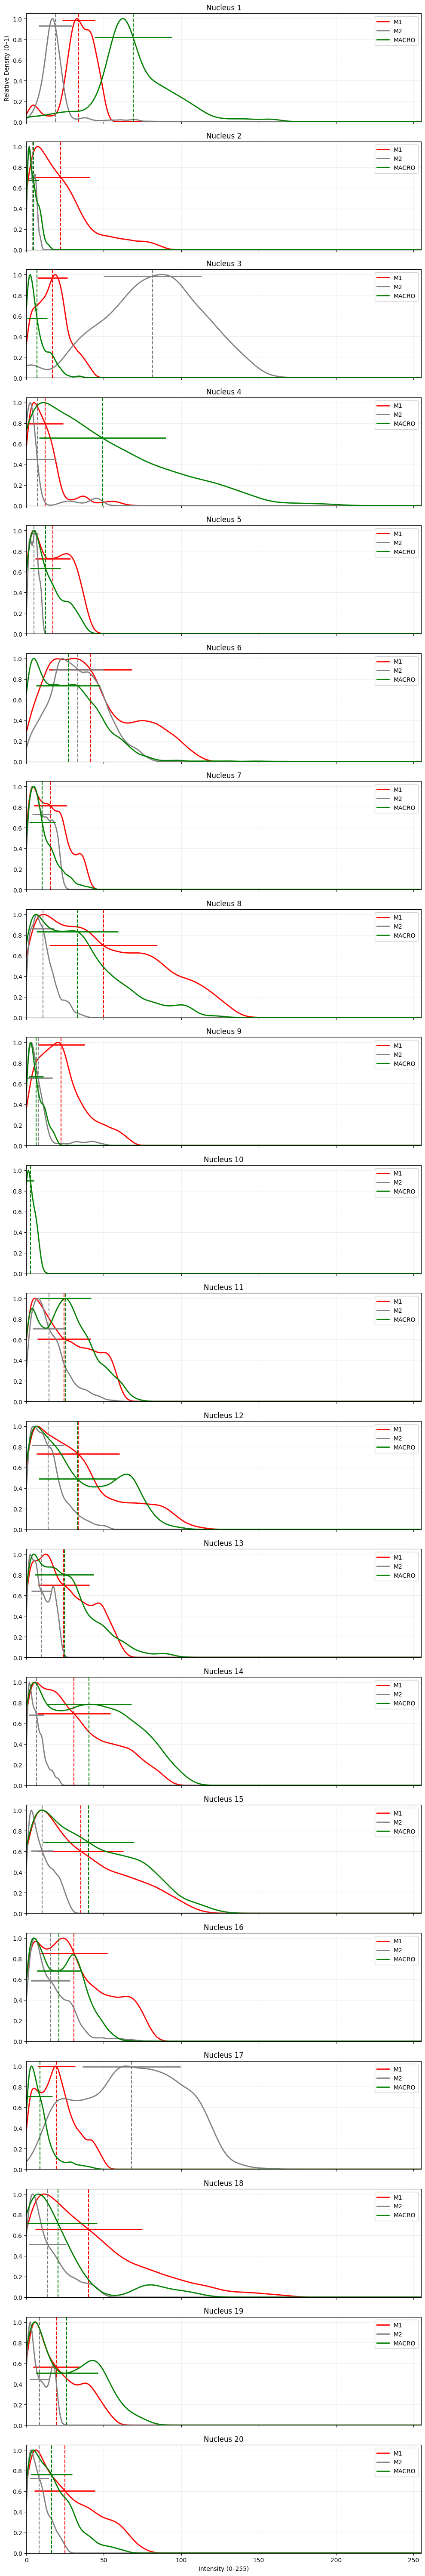

In [39]:
# --- REQUIRE: hist_data must exist in the form hist_data[n][condition] = list(values) ---
# e.g. hist_data = {1: {'MACRO': [...], 'CD3': [...], 'CD20': [...]}, 2: {...}, ...}

# Derive nuclei and condition list from hist_data
nuclei = sorted(hist_data.keys())
if len(nuclei) == 0:
    raise ValueError("hist_data is empty. Fill hist_data before plotting.")

max_n = max(nuclei)
all_conditions = sorted({cond for ndata in hist_data.values() for cond in ndata.keys()})

# Assign consistent colors per condition
color_cycle = plt.cm.tab10
condition_colors = {cond: color_cycle(i % 10) for i, cond in enumerate(all_conditions)}

# Limit figure size to prevent matplotlib rendering errors
max_subplots = min(max_n, 20)  # Cap at 20 subplots
height = min(3 * max_subplots, 60)  # Cap height at 60 inches

# Prepare multi-row figure (one subplot per nucleus)
fig, axes = plt.subplots(max_subplots, 1, figsize=(10, height), sharex=True)
if max_subplots == 1:
    axes = [axes]

x_grid = np.linspace(0, 255, 400)

# Only plot nuclei that fit in the subplot grid
nuclei_to_plot = nuclei[:max_subplots]

for idx, n in enumerate(nuclei_to_plot):
    ax = axes[idx]  # Use subplot index instead of nucleus number
    ax.set_title(f"Nucleus {n}")
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.2)

    # For each condition, plot density if data exists
    for cond in all_conditions:
        vals = np.array(hist_data.get(n, {}).get(cond, []))
        if stain_complete_df['Color'][cond] != 'WHITE':
            color = stain_complete_df['Color'][cond]  
        else:
            color = 'GRAY'

        if vals.size == 0:
            # no data for this nucleus & condition: skip curve plotting
            continue

        # try KDE, fallback if singular
        y_grid = None
        try:
            kde = gaussian_kde(vals)
            y_grid = kde(x_grid)
        except Exception:
            # fallback: create a narrow Gaussian around the mean (handles zero-variance)
            mean_val = vals.mean()
            bw = 1.0  # small bandwidth fallback
            y_grid = np.exp(-0.5 * ((x_grid - mean_val) / bw) ** 2)
        
        # normalize y to 0-1
        if y_grid.max() > 0:
            y_norm = y_grid / y_grid.max()
        else:
            y_norm = y_grid

        # plot density curve
        ax.plot(x_grid, y_norm, linewidth=2, color=color)

        # compute mean and std from raw vals
        mean_val = float(vals.mean())
        std_val = float(vals.std())

        # vertical mean line (same color)
        ax.axvline(mean_val, linestyle='--', linewidth=1.5, color=color)

        # y position for std-line: read normalized KDE at mean (interpolate)
        y_at_mean = np.interp(mean_val, x_grid, y_norm)

        # horizontal std line from mean-std to mean+std (clamped to axis)
        x_start = max(0.0, mean_val - std_val)
        x_end = min(255.0, mean_val + std_val)
        ax.hlines(y_at_mean, x_start, x_end, linewidth=2, color=color)

    # Build a legend showing all conditions with their assigned color (consistent across plots)
    legend_handles = [Line2D([0], [0], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY', lw=2) for c in all_conditions]
    ax.legend(legend_handles, all_conditions, loc='upper right', framealpha=0.9)

    if n == nuclei_to_plot[-1]:
        ax.set_xlabel("Intensity (0–255)")

axes[0].set_ylabel("Relative Density (0–1)")
plt.tight_layout()
plt.show()

In [40]:
# Full block: one nucleus per page, 3 channel crops + merged in one horizontal row
styles = getSampleStyleSheet()

create_row_pdf(
    output_pdf=Path(input_file).stem + "_nuclei_marker.pdf",
    pad=20,
    thumb_size=(2.0 * inch, 2.0 * inch)
)

PDF saved to: EB-014_M1_ST_BX15043_20x_nuclei_marker.pdf


## Evaluate cell distribution in the space

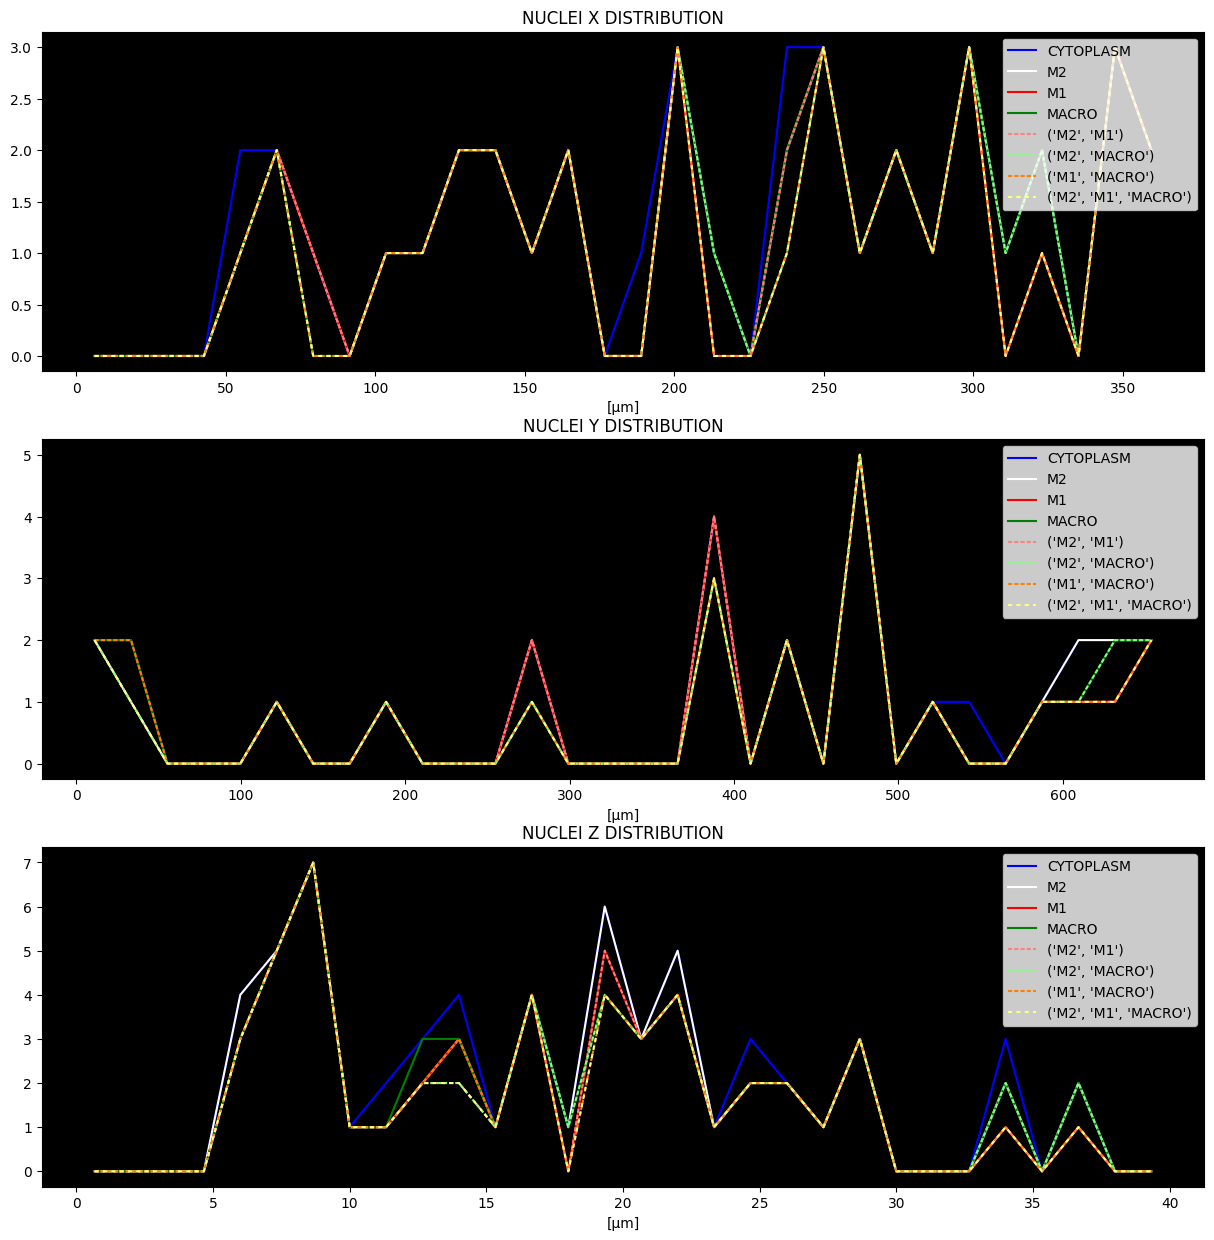

In [41]:
# Plot spatial distribution of nuclei and cells
im_in=im_final_stack['Filtered image']

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i, marker in enumerate(labels_df.index):   
    xcoor = [t[0] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    ycoor = [t[1] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    zcoor = [t[2] for t in labels_df['Mean cytoplasm positions [um]'][i]] 
    xcount, xbins = np.histogram(xcoor, range=(0, im_in.shape[2] * r_X /zoom_factors[2]), bins=30)
    ycount, ybins = np.histogram(ycoor, range=(0, im_in.shape[1] * r_Y /zoom_factors[1]), bins=30)
    zcount, zbins = np.histogram(zcoor, range=(0, im_in.shape[0] * r_Z /zoom_factors[0]), bins=30)
    xbin_centers = (xbins[:-1] + xbins[1:]) / 2
    ybin_centers = (ybins[:-1] + ybins[1:]) / 2
    zbin_centers = (zbins[:-1] + zbins[1:]) / 2
    if (np.size(marker)==1):
        color = stain_complete_df.loc[str(labels_df['Condition'][i])]['Color']
        if color == '':
            color='BLUE'
        if (labels_df['Condition'][i]!='NUCLEI'):
            axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),color=color)
            axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),color=color)
            axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_complete_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        final_rgb = (r_final, g_final, b_final)
        
        axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[0].legend(loc='upper right')
axs[0].set_facecolor('black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[1].legend(loc='upper right')
axs[1].set_facecolor('black')
axs[2].set_title('NUCLEI Z DISTRIBUTION')
axs[2].set_xlabel('[μm]')
axs[2].legend(loc='upper right')
axs[2].set_facecolor('black')

## Evaluate cell size distribution

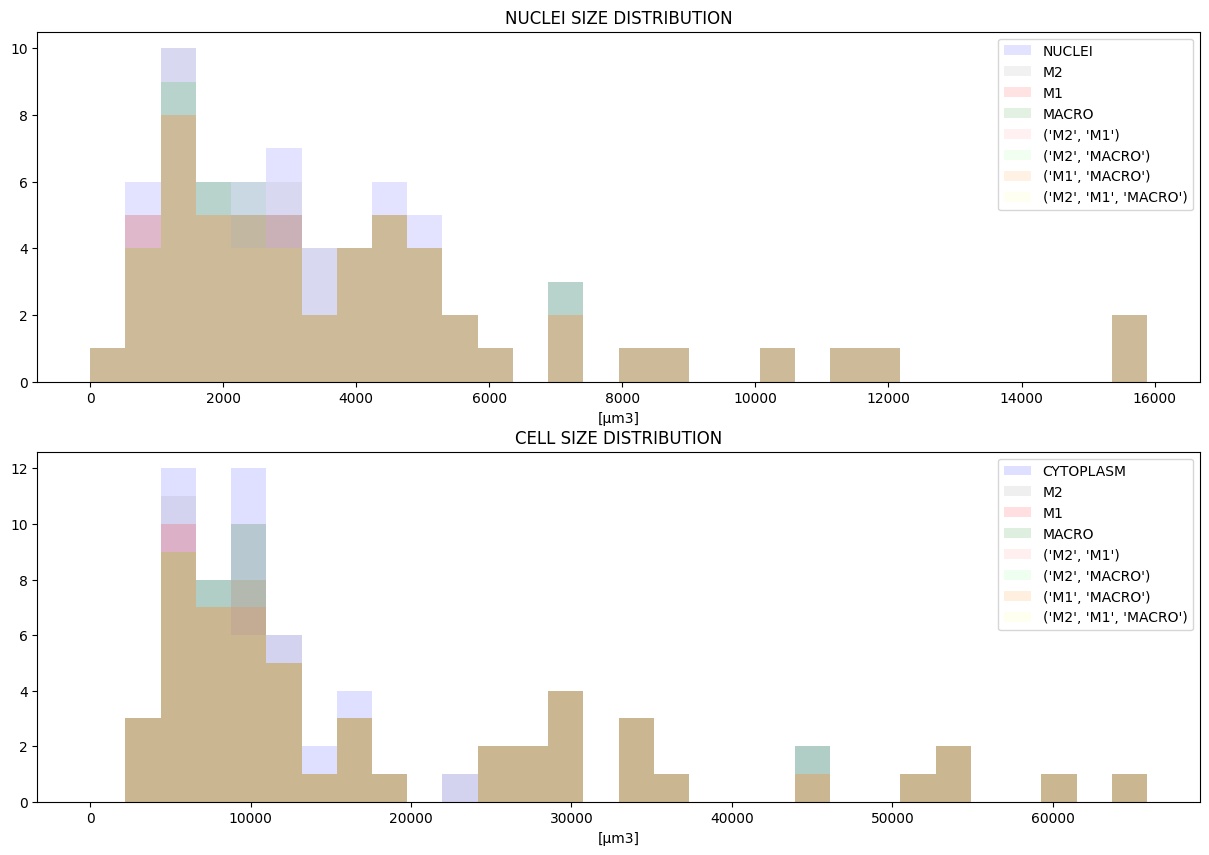

In [42]:
# Plot size distribution of nuclei and cells
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
nuclei_max_size = max(x for t in labels_df['Nuclei size [um3]'] for x in t)
cytoplasm_max_size = max(x for t in labels_df['Cytoplasm size [um3]'] for x in t)
for i, marker in enumerate(labels_df.index):
    nuclei_sizes = list(labels_df['Nuclei size [um3]'][i])
    cell_sizes = list(labels_df['Cytoplasm size [um3]'][i])
    if np.size(marker)==1:
        if stain_complete_df.loc[(labels_df['Condition'][i])]['Color']=='':
            color = 'BLUE'
        else:
            if stain_complete_df.loc[(labels_df['Condition'][i])]['Color']!='WHITE':
                color = stain_complete_df.loc[str(labels_df['Condition'][i])]['Color']
            else:
                color = 'GRAY'
        #color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
        #axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_complete_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        color = (r_final, g_final, b_final)
        
    if labels_df['Condition'][i] != 'CYTOPLASM':    
        axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    if labels_df['Condition'][i] != 'NUCLEI':
        axs[1].hist(cell_sizes, range=(0, cytoplasm_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/(len(labels_df)-1), color=color)
axs[0].set_title('NUCLEI SIZE DISTRIBUTION')
axs[0].set_xlabel('[μm3]')
axs[0].legend(loc='upper right')
axs[1].set_title('CELL SIZE DISTRIBUTION')
axs[1].set_xlabel('[μm3]')
axs[1].legend(loc='upper right')

## CREATE .VTK VOLUME

In [43]:
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
blocks_nuclei=pv.MultiBlock()
blocks_cyto=pv.MultiBlock()
blocks_PCM=pv.MultiBlock()
nuclei_stl_old=mr.Mesh()
cyto_stl_old=mr.Mesh()
PCM_stl_old=mr.Mesh()

nuc_vol=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,))
nuc_coord=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,3))
nuc_list=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,))

cyto_vol=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,))
cyto_coord=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,3))
cyto_list=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,))

PCM_vol=np.zeros((np.max(im_segmentation_stack['PCM'])+1,))
PCM_coord=np.zeros((np.max(im_segmentation_stack['PCM'])+1,3))
PCM_list=np.zeros((np.max(im_segmentation_stack['PCM'])+1,))

#agg_id=1

k=0
for j in range(1,np.max(im_segmentation_stack['Nuclei'])+1):
    clear_output(wait=True)
    print('NUCLEI ' + str(j) + ' / ' + str(np.max(im_segmentation_stack['Nuclei'])))
    
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Nuclei']==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
    
    mesh_nuclei = pv.read("part_nuclei_mesh.stl")
    if mesh_nuclei.volume>0.0:
        mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

        nuc_vol[k]=mesh_nuclei.volume
        nuc_coord[k]=mesh_nuclei.center
        nuc_list[k]=j

        mesh_nuclei.cell_data['ID']=np.ones(mesh_nuclei.n_cells)*(k+1)
        mesh_nuclei.cell_data['Nuclei volume (um3)']=np.ones(mesh_nuclei.n_cells)*nuc_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_nuclei.cell_data['Z nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][0] * r_Z /zoom_factors[0]
        mesh_nuclei.cell_data['Y nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][1] * r_Y /zoom_factors[1]
        mesh_nuclei.cell_data['X nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][2] * r_X /zoom_factors[2]
        
        blocks_nuclei.append(mesh_nuclei)
        k=k+1


    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Cytoplasm']==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
    
    mesh_cyto = pv.read("part_cyto_mesh.stl")

    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['PCM']==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_PCM_mesh.stl" )
    
    mesh_PCM = pv.read("part_PCM_mesh.stl")
    
    if mesh_cyto.volume>0.0:
        mesh_cyto.decimate(target_reduction=0.8, inplace=True)
        mesh_PCM.decimate(target_reduction=0.8, inplace=True)

        cyto_vol[k]=mesh_cyto.volume
        cyto_coord[k]=mesh_cyto.center
        cyto_list[k]=j

        PCM_vol[k]=mesh_PCM.volume
        PCM_coord[k]=mesh_PCM.center
        PCM_list[k]=j

        mesh_cyto.cell_data['ID']=np.ones(mesh_cyto.n_cells)*(k+1)
        mesh_PCM.cell_data['ID']=np.ones(mesh_PCM.n_cells)*(k+1)
        mesh_cyto.cell_data['Cellular volume (um3)']=np.ones(mesh_cyto.n_cells)*cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_PCM.cell_data['PCM volume (um3)']=np.ones(mesh_PCM.n_cells)*PCM_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_cyto.cell_data['Z cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][0] * r_Z /zoom_factors[0]
        mesh_cyto.cell_data['Y cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][1] * r_Y /zoom_factors[1]
        mesh_cyto.cell_data['X cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][2] * r_X /zoom_factors[2]
        mesh_PCM.cell_data['Z PCM (um)']=np.ones(mesh_PCM.n_cells)*PCM_coord[k][0] * r_Z /zoom_factors[0]
        mesh_PCM.cell_data['Y PCM (um)']=np.ones(mesh_PCM.n_cells)*PCM_coord[k][1] * r_Y /zoom_factors[1]
        mesh_PCM.cell_data['X PCM (um)']=np.ones(mesh_PCM.n_cells)*PCM_coord[k][2] * r_X /zoom_factors[2]
        for i, marker in enumerate(labels_full_df.index):
            if (labels_full_df['Condition'][i]!='NUCLEI') & (labels_full_df['Condition'][i]!='CYTOPLASM') & (np.size(marker)==1):
                if j in list(labels_full_df['Shared labels'][i]):
                    mesh_cyto.cell_data[marker+' volume (um3)']=np.ones(mesh_cyto.n_cells)*(labels_full_df['Marker size [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_PCM.cell_data[marker+' volume (um3)']=np.ones(mesh_PCM.n_cells)*(labels_full_df['Marker size [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_cyto.cell_data[marker+' volume cytoplasm (um3)']=np.ones(mesh_cyto.n_cells)*(labels_full_df['Marker size cytoplasm [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_PCM.cell_data[marker+' volume PCM (um3)']=np.ones(mesh_PCM.n_cells)*(labels_full_df['Marker size PCM [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_cyto.cell_data[marker+' rel. vol. (-)']=np.ones(mesh_cyto.n_cells)*((labels_full_df['Marker size [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])/((cyto_vol[k]+PCM_vol[k]) * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                    mesh_PCM.cell_data[marker+' rel. vol. (-)']=np.ones(mesh_PCM.n_cells)*((labels_full_df['Marker size [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])/((cyto_vol[k]+PCM_vol[k]) * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                    mesh_cyto.cell_data[marker+' rel. vol. cytoplasm (-)']=np.ones(mesh_cyto.n_cells)*((labels_full_df['Marker size cytoplasm [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])/(cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                    mesh_PCM.cell_data[marker+' rel. vol. PCM (-)']=np.ones(mesh_PCM.n_cells)*((labels_full_df['Marker size PCM [um3]'][i][list(labels_full_df['Shared labels'][i]).index(j)])/(PCM_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                    mesh_cyto.cell_data[marker+' avg. intensity (-)']=np.ones(mesh_cyto.n_cells)*(labels_full_df['Avg. marker intensity'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_PCM.cell_data[marker+' avg. intensity (-)']=np.ones(mesh_PCM.n_cells)*(labels_full_df['Avg. marker intensity'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_cyto.cell_data[marker+' avg. cytoplasm int. (-)']=np.ones(mesh_cyto.n_cells)*(labels_full_df['Avg. marker intensity cytoplasm'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                    mesh_PCM.cell_data[marker+' avg. PCM int. (-)']=np.ones(mesh_PCM.n_cells)*(labels_full_df['Avg. marker intensity PCM'][i][list(labels_full_df['Shared labels'][i]).index(j)])
                else:
                    mesh_cyto.cell_data[marker+' expression (um3)']=np.ones(mesh_cyto.n_cells)*(0.0)
                    mesh_cyto.cell_data[marker+' rel. expr. (-)']=np.ones(mesh_cyto.n_cells)*(0.0)
                # ass_channel_2=globals()[channel+'mag']*(NUCLEIlab==val)/np.max(globals()[channel+'mag'])
                # mesh_cyto.cell_data[channel+'_perc_rel']=np.ones(mesh_nuclei.n_cells)*(np.sum(ass_channel_2)/np.sum(NUCLEIlab==val))
        
        blocks_cyto.append(mesh_cyto)
        blocks_PCM.append(mesh_PCM)
        #k=k+1

    #j=j-1

# nuc_vol=nuc_vol[0:k-1]
# nuc_coord=nuc_coord[0:k-1]
# nuc_list=nuc_list[0:k-1]
blocks_nuclei.extract_geometry().save(Path(input_file).stem+'_NUCLEI_labelled.vtk')
blocks_cyto.extract_geometry().save(Path(input_file).stem+'_CYTOPLASM_labelled.vtk')
blocks_PCM.extract_geometry().save(Path(input_file).stem+'_PCM_labelled.vtk')

NUCLEI 68 / 68


## and .STL for markers

In [44]:
for c, marker in enumerate(stain_complete_df.index):
    if (stain_complete_df.index[c] != 'NUCLEI') & (stain_complete_df.index[c] != 'CYTOPLASM') & (stain_complete_df.index[c] != 'PCM'):
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack[stain_df.index[c]]>0))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
        mr.saveMesh(mesh_stl,Path(input_file).stem + "_" + stain_complete_df['Marker'][c] + "_mesh.stl" )

### Create a complete report XSL

In [45]:
# Export quantification results to Excel file
with pd.ExcelWriter(Path(input_file).stem + '_segmentation.xlsx', engine='xlsxwriter') as writer:
    original_stain_complete_df.to_excel(writer, sheet_name='Staining', index=True)
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Nuclei size [um3]']
    # for i, marker in enumerate(labels_full_df.index):
    #     if (labels_full_df['Condition'][i] != 'NUCLEI') & (labels_full_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_full_df['Condition'][i])==1):
    #         columns.append(f"{marker} ({labels_full_df['Condition'][i]})")
    #         columns.append(f"{labels_full_df['Condition'][i]} marker size [um3]")
    for k in range(1, int(labels_full_df['Number'][0])):
        row = [labels_full_df['Mean nuclei positions [um]'][0][k-1], labels_full_df['Nuclei size [um3]'][0][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        # for i, marker in enumerate(labels_full_df.index):
        #     if (labels_full_df['Condition'][i] != 'NUCLEI') & (labels_full_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_full_df['Condition'][i])==1):
        #         shared = labels_full_df['Shared labels'][i]
        #         if k in shared:
        #             idx = list(shared).index(k)
        #             #row.append(marker)
        #             row.append(labels_full_df['Marker size [um3]'][marker][idx])
        #         else:
        #             row.extend(['', ''])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='NUCLEI', index=True)  
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Cytoplasm size [um3]']  
    for i, marker in enumerate(labels_full_df.index):
        if (labels_full_df['Condition'][i] != 'NUCLEI') & (labels_full_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_full_df['Condition'][i])==1):
            #columns.append(f"{marker} ({labels_full_df['Condition'][i]})")
            columns.append(f"{labels_full_df.index[i]} marker size [um3]")
            columns.append(f"{labels_full_df.index[i]} marker size cytoplasm [um3]")
            columns.append(f"{labels_full_df.index[i]} marker size PCM [um3]")
            columns.append(f"{labels_full_df.index[i]} intensity [-]")
            columns.append(f"{labels_full_df.index[i]} STD")
            columns.append(f"{labels_full_df.index[i]} intensity cytoplasm [-]")
            columns.append(f"{labels_full_df.index[i]} STD")
            columns.append(f"{labels_full_df.index[i]} intensity PCM [-]")
            columns.append(f"{labels_full_df.index[i]} STD")
    for k in range(1, int(labels_full_df['Number'][0])):
        row = [labels_full_df['Mean cytoplasm positions [um]'][1][k-1], labels_full_df['Cytoplasm size [um3]'][1][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        for i, marker in enumerate(labels_full_df.index):
            if (labels_full_df['Condition'][i] != 'NUCLEI') & (labels_full_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_full_df['Condition'][i])==1):
                shared = labels_full_df['Shared labels'][i]
                if k in shared:
                    idx = list(shared).index(k)
                    #row.append(marker)
                    row.append(labels_full_df['Marker size [um3]'][marker][idx])
                    row.append(labels_full_df['Marker size cytoplasm [um3]'][marker][idx])
                    row.append(labels_full_df['Marker size PCM [um3]'][marker][idx])
                    row.append(labels_full_df['Avg. marker intensity'][marker][idx])
                    row.append(labels_full_df['STD marker intensity'][marker][idx])
                    row.append(labels_full_df['Avg. marker intensity cytoplasm'][marker][idx])
                    row.append(labels_full_df['STD marker intensity cytoplasm'][marker][idx])
                    row.append(labels_full_df['Avg. marker intensity PCM'][marker][idx])
                    row.append(labels_full_df['STD marker intensity PCM'][marker][idx])
                else:
                    row.extend([' ',' ',' ',' ',' ',' ',' ',' ',' '])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='CYTOPLASM', index=True)
    resume_df = labels_full_df.drop(columns=['Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]', 'Avg. marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM'])
    resume_df['Laser'] = [
        labels_full_df['Laser'][t] if (np.size(labels_full_df['Condition'][t])==1) else ''
        for t in range(len(labels_full_df))
    ]
    resume_df['Color'] = [
        labels_full_df['Color'][t] if (np.size(labels_full_df['Condition'][t])==1) else ''
        for t in range(len(labels_full_df))
    ]
    resume_df['%'] = [
        100.0 * labels_full_df['Number'][t] / labels_full_df['Number'][0] if labels_full_df['Condition'][t] != 'NUCLEI' else ''
        for t in range(len(labels_full_df))
    ]
    resume_df['Mean nuclei size [um3]'] = [np.mean(t) for t in labels_full_df['Nuclei size [um3]']]
    resume_df['Mean cytoplasm size [um3]'] = [np.mean(t) for t in labels_full_df['Cytoplasm size [um3]']]
    resume_df['Mean marker size [um3]'] = [
        np.mean(val) if (labels_full_df['Condition'][t] != 'NUCLEI') & (labels_full_df['Condition'][t] != 'CYTOPLASM') & (np.size(labels_full_df['Condition'][t])==1) else ''
        for t, val in enumerate(labels_full_df['Marker size [um3]'])
    ]
    resume_df.to_excel(writer, sheet_name='RECAP', index=True)

fromnumeric.py (3504): Mean of empty slice.
_methods.py (129): invalid value encountered in scalar divide
fromnumeric.py (3504): Mean of empty slice.
_methods.py (129): invalid value encountered in scalar divide


# CREATE .inp FOR FINITE ELEMENT ANALYSIS

In [ ]:
simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Nuclei']))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)

outVerts = mrn.getNumpyVerts(mesh_stl)
#print(outVerts)

outFaces = mrn.getNumpyFaces(mesh_stl.topology)

tet = tetgen.TetGen(outVerts,outFaces)
nodes,elems=tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

tet.write('FE_segmentation_full.vtk', binary=False)

In [ ]:
meshel = meshio.read('FE_segmentation_full.vtk')
meshel.write('FE_segmentation.inp')

for c in range(1, np.max(im_segmentation_stack['Nuclei'])+1):
    globals()[str(c)+'cell_el']=[]

for ce, x in enumerate(elems):
    #print(np.shape(np.uint16(np.mean(nodes[x],0))))
    coord=np.int16(np.round(np.mean(nodes[x],0),0))
    step=0
    taken=False
    while not(taken):
        step+=1
        coord[coord<step]=1
        for k in [0,1,2]:
            if coord[k]>=np.shape(im_segmentation_stack['Nuclei'])[k]+1-step:coord[k]=np.shape(im_segmentation_stack['Nuclei'])[k]-1
        elemlist=im_segmentation_stack['Nuclei'][coord[0]-step:coord[0]+1+step,coord[1]-step:coord[1]+1+step,coord[2]-step:coord[2]+1+step].flatten()
        #print(elemlist)
        if sum(elemlist)>0:
            c_el=st.mode(elemlist[elemlist!=0])
            taken=True

    #print(c_el)
    if c_el!=0:
        globals()[str(c_el)+'cell_el'].append(ce+1)

f = open("FE_segmentation.inp", "a")
for c in range(1,np.max(im_segmentation_stack['Nuclei'])+1):
    f.write("*Elset, elset=cell" + str(c) + "\n")
    j=1
    for t in range(1, np.size(globals()[str(c)+'cell_el'])):
        f.write(str(globals()[str(c)+'cell_el'][t]) + ",")
        j+=1
        if j>16:
            f.write("\n")
            j=1
    f.write("\n")

    
f.close()

In [ ]:
# Now insert *PART header manually
with open("FE_segmentation.inp", "r") as f:
    lines = f.readlines()

with open(Path(input_file).stem + "_FEA.inp", "w") as f:
    for line in lines:
        if (line=="*NODE\n"):
            f.write("*PART, name=Part-1\n")
        f.write(line)
    f.write("*END PART\n")